In [1]:
%pip install PyTDC

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.6 MB/s eta 0:00:00
  Created wheel for PyTDC: filename=PyTDC-0.4.0-py3-none-any.whl size=139519 sha256=05f88ebec8de6dbaf1a85f695e6188e2431b1fad25995ba3916f5aede8766740
  Stored in directory: /root/.cache/pip/wheels/65/da/1a/38e66a2b950c7acc0f41d3bbbc12071653d099baa5402d9c32
Successfully built PyTDC


In [2]:
%pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 26.4 MB/s eta 0:00:00


In [3]:
%pip install pandas-flavor

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm #progress bar
import rdkit
from rdkit import Chem #Chemistry
from rdkit.Chem import rdMolDescriptors #molecular descriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
rdkit.__version__

import xgboost as xgb
import sklearn
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import fbeta_score, make_scorer
from xgboost.sklearn import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split #ML training
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error #ML stats
from yellowbrick.regressor import prediction_error, ResidualsPlot
from tdc.single_pred import ADME
from tdc.benchmark_group import admet_group
from tdc import BenchmarkGroup
import warnings
warnings.filterwarnings("ignore")

In [5]:
group = admet_group(path = 'data/')
predictions_list_xgb = []
best_params_list_xgb = []
predictions_list_rf = []
predictions_list_svm = []
best_params_list_svm = []
predictions_list_adb = []
predictions_list_cnn = []

for seed in [1, 2, 3, 4, 5]:
    predictions_xgb = {}
    predictions_rf = {}
    predictions_svm = {}
    predictions_adb = {}
    predictions_cnn = {}

    benchmark = group.get('PPBR_AZ')
    name = benchmark['name']
    train_val, test = benchmark['train_val'], benchmark['test']
    train, valid = group.get_train_valid_split(benchmark = name, split_type = 'default', seed = seed)

    PandasTools.AddMoleculeColumnToFrame(train, smilesCol='Drug')
    radius=2
    nBits=1024
    ECFP6 = [AllChem.GetMorganFingerprintAsBitVect(x,radius=radius, nBits=nBits) for x in train['ROMol']]
    ecfp6_name = [f'Bit_{i}' for i in range(nBits)]
    ecfp6_bits = [list(l) for l in ECFP6]
    Y = train['Y']
    train = pd.DataFrame(ecfp6_bits, index = train.Drug, columns=ecfp6_name).reset_index(drop = False)
    train['Y'] = Y

    PandasTools.AddMoleculeColumnToFrame(benchmark['test'], smilesCol='Drug')
    radius=2
    nBits=1024
    ECFP6 = [AllChem.GetMorganFingerprintAsBitVect(x,radius=radius, nBits=nBits) for x in benchmark['test']['ROMol']]
    ecfp6_name = [f'Bit_{i}' for i in range(nBits)]
    ecfp6_bits = [list(l) for l in ECFP6]
    Y = benchmark['test']['Y']
    benchmark['test'] = pd.DataFrame(ecfp6_bits, index = benchmark['test'].Drug, columns=ecfp6_name).reset_index(drop = False)
    benchmark['test']['Y'] = Y

    train_X = train.drop(columns = ["Drug","Y"])
    train_y = train.Y
    test_X = benchmark['test'].drop(columns = ["Drug","Y"])
    test_y = benchmark['test'].Y


    #XGBoost + Morgan
    xgb_parameters = {'objective':['reg:squarederror'],
              'booster':['gbtree','gblinear'],
              'learning_rate': [0.1],
              'max_depth': [7,10,15,20],
              'min_child_weight': [10,15,20,25],
              'colsample_bytree': [0.8, 0.9, 1],
              'n_estimators': [300,400,500,600],
              "reg_alpha"   : [0.5,0.2,1],
              "reg_lambda"  : [2,3,5],
              "gamma"       : [1,2,3]}

    xgb_model = XGBRegressor()
    grid_obj_xgb = RandomizedSearchCV(xgb_model, xgb_parameters, cv=5, n_iter=15, scoring='neg_mean_absolute_error', verbose=5, n_jobs=1)
    grid_obj_xgb.fit(train_X, train_y, verbose = 1)
    y_pred_test_xgb = grid_obj_xgb.predict(test_X)
    bp_xgb = grid_obj_xgb.best_params_
    predictions_xgb[name] = y_pred_test_xgb
    predictions_list_xgb.append(predictions_xgb)
    best_params_list_xgb.append(bp_xgb)

    #Random Forest + Morgan
    rf_model = RandomForestRegressor()
    rf_model.fit(train_X, train_y)
    y_pred_test_rf = rf_model.predict(test_X)
    predictions_rf[name] = y_pred_test_rf
    predictions_list_rf.append(predictions_rf)

    #SVM + Morgan
    svm_parameters = {
        'C': [0.1, 1, 10, 100, 1000],
        'epsilon': [0.0001, 0.001, 0.01, 0.1, 0.5],
        'gamma': [0.0001, 0.001, 0.01, 0.1, 1]
    }
    svm_model = SVR(kernel="rbf")
    grid_obj_svm = RandomizedSearchCV(svm_model, svm_parameters, cv=5, n_iter=15, scoring='neg_mean_absolute_error', verbose=5, n_jobs=1)
    grid_obj_svm.fit(train_X, train_y)
    y_pred_test_svm = grid_obj_svm.predict(test_X)
    bp_svm = grid_obj_svm.best_params_
    predictions_svm[name] = y_pred_test_svm
    predictions_list_svm.append(predictions_svm)
    best_params_list_svm.append(bp_svm)

    # AdaBoost + Morgan
    DTR = DecisionTreeRegressor(max_depth=4)
    adb_model = AdaBoostRegressor(n_estimators=300, base_estimator=DTR, learning_rate=1)
    adb_model.fit(train_X, train_y)
    y_pred_test_adb = adb_model.predict(test_X)
    predictions_adb[name] = y_pred_test_adb
    predictions_list_adb.append(predictions_adb)

    #CNN + Morgan
    train_X = train_X.to_numpy()
    test_X = test_X.to_numpy()
    train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
    test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)
    cnn_model = Sequential()
    cnn_model.add(Conv1D(32, 2, activation="relu", input_shape=(1024,1)))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(64, activation="relu"))
    cnn_model.add(Dense(1))
    cnn_model.compile(loss="mse", optimizer="adam")
    cnn_model.fit(train_X, train_y, batch_size=12, epochs=10, verbose=0)
    y_pred_test_cnn = cnn_model.predict(test_X)
    predictions_cnn[name] = y_pred_test_cnn
    predictions_list_cnn.append(predictions_cnn)

xgb_results = group.evaluate_many(predictions_list_xgb)
rf_results = group.evaluate_many(predictions_list_rf)
svm_results = group.evaluate_many(predictions_list_svm)
adb_results = group.evaluate_many(predictions_list_adb)
cnn_results = group.evaluate_many(predictions_list_cnn)



100%|██████████| 1.47M/1.47M [00:01<00:00, 1.33MiB/s]
Extracting zip file...
Done!
generating training, validation splits...
100%|██████████| 2231/2231 [00:01<00:00, 1719.47it/s]


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[03:37:01] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[CV 1/5] END booster=gblinear, colsample_bytree=1, gamma=3, learning_rate=0.1, max_depth=10, min_child_weight=25, n_estimators=300, objective=reg:squarederror, reg_alpha=1, reg_lambda=5;, score=-14.711 total time=  14.2s
[03:37:16] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[CV 2/5] END booster=gblinear, colsample_bytree=1, gamma=3, learning_rate=0.1, max_depth=10, min_child_weight=25, n_estimators=300, objective=reg:squarederror, reg_alpha=1, reg_lambda=5;, score=-13.476 total time=   4.6s
[03:37:20] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[CV 3/5] END booster=gblinear, colsample_bytree=1, gamma=3, learning_rate=0.1, max_depth=

generating training, validation splits...
100%|██████████| 2231/2231 [00:01<00:00, 1690.71it/s]


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[04:15:54] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[CV 1/5] END booster=gblinear, colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=20, min_child_weight=10, n_estimators=600, objective=reg:squarederror, reg_alpha=0.2, reg_lambda=3;, score=-12.457 total time=  10.0s
[04:16:04] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[CV 2/5] END booster=gblinear, colsample_bytree=0.9, gamma=2, learning_rate=0.1, max_depth=20, min_child_weight=10, n_estimators=600, objective=reg:squarederror, reg_alpha=0.2, reg_lambda=3;, score=-12.374 total time=   9.2s
[04:16:13] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[CV 3/5] END booster=gblinear, colsample_bytree=0.9, gamma=2, learning_rate=0.1, 

generating training, validation splits...
100%|██████████| 2231/2231 [00:01<00:00, 1720.14it/s]


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[05:12:17] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[CV 1/5] END booster=gblinear, colsample_bytree=1, gamma=2, learning_rate=0.1, max_depth=15, min_child_weight=15, n_estimators=400, objective=reg:squarederror, reg_alpha=0.2, reg_lambda=2;, score=-13.136 total time=   7.4s
[05:12:24] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[CV 2/5] END booster=gblinear, colsample_bytree=1, gamma=2, learning_rate=0.1, max_depth=15, min_child_weight=15, n_estimators=400, objective=reg:squarederror, reg_alpha=0.2, reg_lambda=2;, score=-12.576 total time=   5.4s
[05:12:30] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[CV 3/5] END booster=gblinear, colsample_bytree=1, gamma=2, learning_rate=0.1, max_de

generating training, validation splits...
100%|██████████| 2231/2231 [00:02<00:00, 1028.51it/s]


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END booster=gbtree, colsample_bytree=0.8, gamma=2, learning_rate=0.1, max_depth=20, min_child_weight=25, n_estimators=400, objective=reg:squarederror, reg_alpha=1, reg_lambda=2;, score=-13.261 total time= 1.1min
[CV 2/5] END booster=gbtree, colsample_bytree=0.8, gamma=2, learning_rate=0.1, max_depth=20, min_child_weight=25, n_estimators=400, objective=reg:squarederror, reg_alpha=1, reg_lambda=2;, score=-11.526 total time= 1.2min
[CV 3/5] END booster=gbtree, colsample_bytree=0.8, gamma=2, learning_rate=0.1, max_depth=20, min_child_weight=25, n_estimators=400, objective=reg:squarederror, reg_alpha=1, reg_lambda=2;, score=-10.984 total time= 1.2min
[CV 4/5] END booster=gbtree, colsample_bytree=0.8, gamma=2, learning_rate=0.1, max_depth=20, min_child_weight=25, n_estimators=400, objective=reg:squarederror, reg_alpha=1, reg_lambda=2;, score=-10.596 total time= 1.2min
[CV 5/5] END booster=gbtree, colsample_bytree=0.8, gamm

generating training, validation splits...
100%|██████████| 2231/2231 [00:01<00:00, 1701.70it/s]


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[06:39:12] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[CV 1/5] END booster=gblinear, colsample_bytree=0.9, gamma=3, learning_rate=0.1, max_depth=7, min_child_weight=10, n_estimators=500, objective=reg:squarederror, reg_alpha=0.2, reg_lambda=3;, score=-12.647 total time=   6.6s
[06:39:19] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[CV 2/5] END booster=gblinear, colsample_bytree=0.9, gamma=3, learning_rate=0.1, max_depth=7, min_child_weight=10, n_estimators=500, objective=reg:squarederror, reg_alpha=0.2, reg_lambda=3;, score=-15.202 total time=   8.6s
[06:39:28] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.

[CV 3/5] END booster=gblinear, colsample_bytree=0.9, gamma=3, learning_rate=0.1, ma

In [6]:
xgb_results

{'ppbr_az': [9.995, 0.148]}

In [7]:
rf_results

{'ppbr_az': [10.385, 0.184]}

In [8]:
svm_results

{'ppbr_az': [9.108, 0.328]}

In [9]:
adb_results

{'ppbr_az': [17.474, 3.328]}

In [10]:
cnn_results

{'ppbr_az': [12.45, 0.577]}

In [ ]:
predictions_list_cnn = [{'ppbr_az': np.array( [72.70573 ,
          72.70573 ,
          92.53755 ,
          92.53755 ,
          58.826862,
          72.686134,
          58.826862,
          72.686134,
          92.76341 ,
          96.62754 ,
          69.26505 ,
          92.87788 ,
          69.26505 ,
          92.87788 ,
          92.87788 ,
          57.15791 ,
          69.26505 ,
          71.58049 ,
          79.74839 ,
         111.84225 ,
          65.71501 ,
         107.95927 ,
          90.44085 ,
          70.30283 ,
          70.30283 ,
          70.30283 ,
         104.00534 ,
         100.73825 ,
         100.73825 ,
         104.00534 ,
         104.38159 ,
         105.63886 ,
          76.00536 ,
          76.00536 ,
          95.79365 ,
          95.79365 ,
          69.476204,
          69.476204,
          69.476204,
          69.476204,
          69.476204,
          69.476204,
          69.476204,
          69.476204,
          74.9987  ,
          93.14329 ,
         110.548836,
          76.36887 ,
          76.36887 ,
          76.36887 ,
          76.36887 ,
          76.36887 ,
          76.36887 ,
          97.87429 ,
          93.30372 ,
          94.79215 ,
          99.61738 ,
          93.30372 ,
          83.604675,
          99.44018 ,
          83.604675,
          81.36913 ,
          99.44018 ,
          91.42793 ,
          83.427475,
         107.512276,
         109.04281 ,
          85.71511 ,
          85.71511 ,
          83.48908 ,
          83.48908 ,
          54.85447 ,
          61.08533 ,
          61.08533 ,
          82.68283 ,
          82.68283 ,
          82.68283 ,
          74.059845,
          94.994354,
          83.24775 ,
         102.727394,
          82.68283 ,
          78.53401 ,
         102.727394,
         102.727394,
          81.21143 ,
          90.190956,
          81.21143 ,
          81.21143 ,
          90.190956,
          90.190956,
          96.88706 ,
          96.88706 ,
         117.050995,
          92.241325,
          83.26554 ,
          83.26554 ,
         105.66359 ,
         105.66359 ,
         105.66359 ,
          53.947437,
          53.947437,
          53.947437,
          75.81473 ,
          83.42155 ,
          83.42155 ,
          69.20549 ,
         110.31414 ,
         110.31414 ,
         102.56    ,
          95.43166 ,
          95.43166 ,
          80.306755,
          73.87354 ,
          73.87354 ,
          73.87354 ,
          92.58528 ,
          84.43647 ,
          90.01585 ,
          85.528984,
          90.30735 ,
          90.30735 ,
         108.58548 ,
          90.4842  ,
          90.4842  ,
          79.92546 ,
          79.92545 ,
          79.92545 ,
          81.9684  ,
          85.74552 ,
          84.18996 ,
          84.18996 ,
          81.9684  ,
          85.74552 ,
          81.9684  ,
          85.74552 ,
          81.13979 ,
          81.13979 ,
          60.73862 ,
         111.22054 ,
         126.16579 ,
          58.534874,
          74.81737 ,
         101.850845,
         100.88326 ,
          97.13233 ,
          99.07657 ,
         102.35229 ,
          97.32383 ,
         106.78856 ,
         103.68903 ,
         104.19353 ,
         114.22808 ,
          94.905624,
         111.17754 ,
         102.309204,
         102.309204,
          95.27979 ,
         110.345   ,
          69.371895,
          69.371895,
          77.042755,
          77.042755,
         104.68049 ,
         104.68049 ,
         104.68049 ,
          83.28449 ,
          95.29099 ,
          74.87469 ,
          68.68045 ,
          49.12296 ,
          85.36289 ,
          85.36289 ,
          82.031425,
          82.031425,
          82.031425,
          82.031425,
          91.437675,
          91.437675,
          91.437675,
          91.437675,
         125.78775 ,
          90.581215,
          88.98708 ,
          77.193306,
          85.241356,
          85.241356,
          85.241356,
          89.62377 ,
          86.992294,
          86.9923  ,
          89.95746 ,
          89.957466,
          89.957466,
         122.95719 ,
          94.272675,
         103.1262  ,
          77.7491  ,
          77.7491  ,
          77.60115 ,
          77.60115 ,
          81.13343 ,
          79.124825,
          79.124825,
         102.91563 ,
          99.36053 ,
         104.038734,
         104.038734,
          99.36053 ,
         104.038734,
         108.55862 ,
          85.06109 ,
          87.89471 ,
          90.860916,
          91.95025 ,
          90.63473 ,
          96.47239 ,
          85.5259  ,
          86.53038 ,
         103.48629 ,
         115.52691 ,
         115.52691 ,
         115.52691 ,
         115.52691 ,
         116.88523 ,
          94.77395 ,
          93.602974,
         107.18343 ,
          94.77395 ,
         105.80738 ,
         107.18343 ,
         105.80738 ,
         102.76756 ,
         102.76756 ,
         105.80738 ,
         110.90615 ,
          94.77395 ,
          93.602974,
         115.59648 ,
         110.90615 ,
         107.18343 ,
         115.59648 ,
          94.77395 ,
         103.45339 ,
         122.71314 ,
         103.45339 ,
         110.90615 ,
         108.54406 ,
         108.54406 ,
          93.602974,
         105.80738 ,
         105.80738 ,
         103.45339 ,
         122.71314 ,
         102.767555,
         107.18343 ,
         115.59648 ,
          96.92912 ,
          98.53829 ,
         103.1818  ,
         109.669075,
         109.669075,
         101.91466 ,
         109.669075,
         101.02737 ,
          93.2041  ,
          93.2041  ,
          93.19352 ,
          93.00622 ,
         101.91466 ,
          93.00622 ,
         102.04405 ,
          93.19352 ,
          85.6545  ,
          88.131714,
          99.42719 ,
          83.1658  ,
          96.427895,
          96.427895,
          60.447308,
          60.447308,
          82.98577 ,
          86.716194,
          86.716194,
          94.13865 ,
         107.719025,
          88.70313 ,
          79.030014,
         103.299126,
         103.299126,
         115.78016 ,
          71.34412 ,
          80.88215 ,
          52.937275,
          78.0127  ,
         109.98295 ,
          65.769615,
          74.010735,
          82.71078 ,
          82.71078 ,
          93.63596 ,
          82.71078 ,
          82.71078 ,
          93.63596 ,
          93.63596 ,
          82.71078 ,
          55.703312,
          55.703312,
          55.703312,
          84.423485,
          84.423485,
          53.651268,
         132.60959 ,
          77.016136,
          77.016136,
          76.06345 ,
          76.06345 ,
          83.54943 ,
          97.65406 ,
          97.7365  ,
          97.7365  ,
          90.53636 ,
          90.53636 ,
          90.53636 ,
          90.53636 ,
          93.341965,
          93.341965,
          97.576836,
          97.576836,
          93.341965,
          74.25559 ,
          81.89863 ,
          81.89863 ,
          74.25559 ,
         101.37469 ,
          99.0207  ,
         101.37469 ,
         101.37469 ,
          87.84081 ,
          95.30447 ,
          99.0207  ,
          95.30447 ,
          95.30447 ,
          92.52022 ,
          95.93249 ,
         101.178764,
          87.70394 ,
         115.89634 ,
          87.23118 ,
          98.40141 ,
          98.40141 ,
         100.82891 ,
          99.67016 ,
          93.73927 ,
          93.73927 ,
          93.73927 ,
          93.73927 ,
          93.73927 ,
         112.36429 ,
         105.633995,
          61.65198 ,
          61.65198 ,
          92.03942 ,
          82.27775 ,
         100.73945 ,
          86.44944 ,
          86.44944 ,
          86.44944 ,
          76.23775 ,
          76.23775 ,
          91.7925  ,
          90.76838 ,
          91.7925  ,
          88.44218 ,
         104.801414,
         100.95558 ,
         100.95558 ,
         111.70052 ,
         111.70052 ,
         111.70052 ,
          68.833015,
          68.833015,
         102.29914 ,
         102.29914 ,
         102.29914 ,
         129.45737 ,
         129.45737 ,
         107.5425  ,
          74.866394,
          74.866394,
          74.866394,
          87.59768 ,
          87.59768 ,
          87.59768 ,
          96.97804 ,
          86.87257 ,
          76.195755,
          78.743355,
          83.53185 ,
          80.31658 ,
          98.12258 ,
          96.173485,
          95.75384 ,
          90.16567 ,
          90.16567 ,
          87.70046 ,
         100.91216 ,
         100.91216 ,
          92.182846,
          83.77369 ,
          89.42398 ,
          84.340614,
          79.914055,
          98.22415 ,
          98.22415 ,
          67.74991 ,
          67.74991 ,
          67.74991 ,
          78.441826,
          83.7544  ,
          97.75747 ,
          87.55218 ,
          83.7544  ,
          97.75747 ,
          88.045654,
          88.045654,
          87.55218 ,
          97.75747 ,
          90.09653 ,
          74.30599 ,
          84.16576 ,
          62.574844,
         106.58152 ,
         106.58152 ,
         103.788216,
          80.11537 ,
          75.38787 ,
          92.520195,
          92.520195,
         108.12342 ,
         104.70382 ,
          85.07084 ,
          85.07084 ,
          85.07084 ,
          92.61593 ,
          59.391857,
          66.72429 ,
          66.72429 ,
         117.82486 ,
         113.18115 ,
         116.85462 ,
         107.38107 ,
         104.977646,
         112.08541 ,
         113.015785,
         106.7007  ,
          75.97097 ,
          75.97097 ,
         108.34548 ,
          84.52024 ,
          84.52024 ,
          84.52024 ,
          87.391914,
          87.391914,
          87.391914,
          86.8225  ,
          74.09785 ,
          83.76345 ,
          96.356285,
          96.356285,
          81.444115,
          81.444115,
          81.444115,
         115.500275,
          85.92144 ,
          85.92144 ,
          67.93987 ,
          67.93987 ,
          87.58979 ,
          87.58979 ,
          87.58979 ,
         106.278275,
          67.38315 ,
          82.606445,
          82.606445,
          67.38315 ,
          67.38315 ,
          93.95198 ,
         101.31928 ,
          72.34838 ,
         108.79277 ,
         108.79277 ,
         108.79277 ,
         108.79277 ,
          84.67368 ,
          77.26481 ,
          98.58945 ,
          66.16953 ,
         115.252655,
         107.763336,
         115.15062 ,
         100.07023 ,
         118.054825,
         110.770515,
         118.86816 ,
         118.86816 ,
         118.86816 ,
          96.988045,
          70.082954,
          84.7763  ,
          70.082954,
          84.7763  ,
          65.68555 ,
          89.05308 ,
          93.37696 ,
          93.37696 ,
          65.57076 ,
          53.539875,
          77.12949 ,
          77.12949 ,
          77.41738 ,
          77.41738 ,
         104.28482 ,
          98.84884 ,
         104.28482 ,
          73.63934 ,
          73.63934 ,
          73.63934 ,
          73.63934 ,
          71.80322 ,
          85.607216,
          85.607216,
          85.607216,
         102.086334,
          78.473526,
         102.086334,
          78.473526,
          74.21897 ,
         102.086334,
          78.473526,
          66.36637 ,
          88.77795 ,
         109.89474 ,
         119.37558 ,
         128.17389 ,
         112.95527 ,
         116.18328 ,
         115.46642 ,
          54.266808,
          54.266808,
          94.92603 ,
          94.92603 ,
         100.031845,
         100.031845,
          69.244225,
          74.916725,
          72.74898 ,
          72.74898 ,
          86.23445 ])},
 {'ppbr_az': np.array( [62.62131 ,
          62.62131 ,
          92.58664 ,
          92.58664 ,
          66.968124,
          75.964005,
          66.968124,
          75.964005,
          86.52343 ,
          97.01784 ,
          68.47726 ,
          91.45349 ,
          68.47726 ,
          91.45349 ,
          91.45349 ,
          62.532852,
          68.47726 ,
          74.96559 ,
          83.86953 ,
         110.93567 ,
          74.99234 ,
         102.85887 ,
          97.80455 ,
          68.70189 ,
          68.70189 ,
          68.70189 ,
          92.56738 ,
          89.2684  ,
          89.2684  ,
          92.56738 ,
         101.72447 ,
          95.37474 ,
          79.81877 ,
          79.81877 ,
          94.96947 ,
          94.96947 ,
          71.01503 ,
          71.01503 ,
          71.01503 ,
          71.01503 ,
          71.01503 ,
          71.01503 ,
          71.01503 ,
          71.01503 ,
          84.75702 ,
          98.75017 ,
         103.95419 ,
          79.703636,
          79.703636,
          79.703636,
          79.703636,
          79.703636,
          79.703636,
         105.30317 ,
          90.06055 ,
          78.20066 ,
          85.45482 ,
          90.06055 ,
          78.116516,
          89.24279 ,
          78.116516,
          72.110664,
          89.24278 ,
          83.036896,
          81.904495,
          89.04173 ,
          86.53247 ,
          89.38479 ,
          89.38479 ,
          71.244   ,
          71.244   ,
          68.79887 ,
          63.729805,
          63.729805,
          81.14676 ,
          81.14676 ,
          81.14676 ,
          74.91153 ,
          93.997986,
          79.3406  ,
          93.82607 ,
          81.14676 ,
          78.979164,
          93.82607 ,
          93.82607 ,
          82.086975,
          87.51843 ,
          82.086975,
          82.086975,
          87.51843 ,
          87.51843 ,
          84.65796 ,
          84.65796 ,
         106.873825,
          85.97551 ,
          97.03256 ,
          97.03256 ,
         104.864914,
         104.864914,
         104.864914,
          49.90897 ,
          49.90897 ,
          49.90897 ,
          77.50127 ,
          76.59361 ,
          76.59361 ,
          63.449104,
         117.07045 ,
         117.07045 ,
          99.68366 ,
          93.92265 ,
          93.92265 ,
          81.27496 ,
          79.72066 ,
          79.72066 ,
          79.72066 ,
          79.80059 ,
          75.80171 ,
          78.00698 ,
          81.7903  ,
          82.073555,
          82.073555,
         115.423096,
          92.27706 ,
          92.27706 ,
          70.00922 ,
          70.00922 ,
          70.00922 ,
          78.24039 ,
          87.393196,
          76.0717  ,
          76.0717  ,
          78.24039 ,
          87.393196,
          78.24039 ,
          87.393196,
          76.29209 ,
          76.29209 ,
          53.215073,
          98.46598 ,
         109.920654,
          61.94411 ,
          78.67922 ,
          93.747955,
          97.47432 ,
          90.987854,
          93.083466,
          95.91392 ,
          96.20885 ,
         101.251045,
          99.37325 ,
          99.105484,
         100.1108  ,
          90.49396 ,
         102.736374,
         108.64107 ,
         108.64107 ,
          78.28372 ,
         107.05177 ,
          58.172367,
          58.17237 ,
          79.38665 ,
          79.38665 ,
         104.09628 ,
         104.09628 ,
         104.09628 ,
          85.35452 ,
          94.84414 ,
          80.79959 ,
          74.20132 ,
          56.668125,
          93.582   ,
          93.582   ,
          84.168724,
          84.168724,
          84.168724,
          84.168724,
          96.59105 ,
          96.59105 ,
          96.59105 ,
          96.59105 ,
         112.438255,
          87.3454  ,
          86.03487 ,
          85.92808 ,
          86.8258  ,
          86.8258  ,
          86.8258  ,
          76.93877 ,
          67.27243 ,
          67.27243 ,
          91.007416,
          91.007416,
          91.007416,
         118.23249 ,
          88.721176,
         101.33141 ,
          81.230515,
          81.230515,
          93.30411 ,
          93.30411 ,
          84.98921 ,
          77.656944,
          77.656944,
         110.54138 ,
          90.01405 ,
          89.19397 ,
          89.19397 ,
          90.01405 ,
          89.19397 ,
          96.39995 ,
          95.16575 ,
          86.17952 ,
          86.98239 ,
          88.139336,
          87.17659 ,
          90.00697 ,
          82.65411 ,
          81.00917 ,
         103.79886 ,
         119.76899 ,
         119.76899 ,
         119.769   ,
         119.769   ,
         101.31827 ,
          89.25911 ,
          87.0594  ,
          95.00318 ,
          89.25911 ,
          95.53854 ,
          95.00318 ,
          95.53854 ,
          88.37132 ,
          88.37132 ,
          95.53854 ,
         109.4993  ,
          89.25911 ,
          87.0594  ,
         109.58124 ,
         109.4993  ,
          95.00318 ,
         109.58124 ,
          89.25911 ,
          96.94013 ,
         110.70911 ,
          96.94013 ,
         109.4993  ,
         100.76483 ,
         100.76483 ,
          87.0594  ,
          95.53854 ,
          95.53854 ,
          96.94013 ,
         110.70911 ,
          88.37133 ,
          95.00319 ,
         109.58124 ,
          97.96927 ,
         101.24208 ,
          98.15613 ,
         101.47512 ,
         101.47512 ,
          93.931625,
         101.47512 ,
          89.2339  ,
          84.31353 ,
          84.31353 ,
          93.27492 ,
          87.97214 ,
          93.931625,
          87.97214 ,
          92.03085 ,
          93.27492 ,
          87.71207 ,
          80.01078 ,
         104.02795 ,
          81.48976 ,
          95.94906 ,
          95.94906 ,
          68.39128 ,
          68.39128 ,
          80.92601 ,
          95.33476 ,
          95.33476 ,
          97.555786,
          99.44298 ,
          92.32208 ,
          81.40271 ,
          96.88112 ,
          96.88112 ,
         109.209526,
          67.53781 ,
          74.058014,
          69.24558 ,
          83.41909 ,
         101.46847 ,
          60.96253 ,
          73.60965 ,
          80.45456 ,
          80.45456 ,
          81.05562 ,
          80.45456 ,
          80.45456 ,
          81.05562 ,
          81.05562 ,
          80.45456 ,
          44.277187,
          44.277187,
          44.277187,
          89.87655 ,
          89.87655 ,
          63.788307,
         125.196335,
          81.13661 ,
          81.13661 ,
          96.92365 ,
          96.92365 ,
          89.12637 ,
          76.945724,
          88.65187 ,
          88.65187 ,
          86.13954 ,
          86.13954 ,
          86.13954 ,
          86.13954 ,
          86.05467 ,
          86.05467 ,
          87.76494 ,
          87.76494 ,
          86.05467 ,
          81.11763 ,
          86.979095,
          86.979095,
          81.11763 ,
          92.79868 ,
          94.20027 ,
          92.79868 ,
          92.79868 ,
          82.416306,
          90.82312 ,
          94.20027 ,
          90.82312 ,
          90.82312 ,
          90.80908 ,
          94.35188 ,
         112.20556 ,
          76.70294 ,
         103.409485,
          85.255585,
          89.499664,
          89.49966 ,
         100.195786,
          88.83936 ,
          85.38403 ,
          85.38403 ,
          85.38403 ,
          85.38403 ,
          85.38403 ,
         108.65741 ,
         100.60922 ,
          71.09677 ,
          71.09677 ,
          91.52097 ,
          81.797134,
          94.67508 ,
          83.45745 ,
          83.45745 ,
          83.45745 ,
          72.97841 ,
          72.97841 ,
          92.88806 ,
          88.68554 ,
          92.88806 ,
          96.53351 ,
         107.28986 ,
         101.55142 ,
         101.55142 ,
         108.526115,
         108.526115,
         108.526115,
          70.24721 ,
          70.24721 ,
          98.3208  ,
          98.3208  ,
          98.32079 ,
         118.69275 ,
         118.69275 ,
         105.88376 ,
          86.45293 ,
          86.45293 ,
          86.45293 ,
          83.03985 ,
          83.03985 ,
          83.03985 ,
          92.73443 ,
          79.00146 ,
          71.609146,
          79.20445 ,
          81.25172 ,
          76.05236 ,
          93.90454 ,
          92.578865,
          91.66842 ,
          96.38756 ,
          96.38756 ,
          96.06141 ,
          93.2755  ,
          93.2755  ,
          98.170395,
          83.731926,
          94.57851 ,
          93.40539 ,
          84.57216 ,
          95.73671 ,
          95.73671 ,
          63.838116,
          63.838116,
          63.838116,
          84.77628 ,
          72.337685,
          87.24165 ,
          80.12143 ,
          72.337685,
          87.24165 ,
          80.81849 ,
          80.81849 ,
          80.12143 ,
          87.24165 ,
          85.45236 ,
          78.49982 ,
          82.03529 ,
          71.74495 ,
         114.29748 ,
         114.29748 ,
          96.2484  ,
          94.3152  ,
          72.07669 ,
          89.925064,
          89.925064,
         104.26166 ,
         109.37155 ,
          94.63338 ,
          94.63338 ,
          94.63338 ,
          88.18547 ,
          54.001762,
          65.6747  ,
          65.6747  ,
         104.05553 ,
          99.77409 ,
         101.40697 ,
          91.163055,
         100.85626 ,
          99.765045,
         108.39528 ,
         104.55345 ,
          53.556576,
          53.556576,
         111.30934 ,
          81.30411 ,
          81.30411 ,
          81.30411 ,
          80.76549 ,
          80.76549 ,
          80.76549 ,
          95.85605 ,
          65.46805 ,
          73.30881 ,
          97.57158 ,
          97.57158 ,
          82.0534  ,
          82.0534  ,
          82.0534  ,
         105.18802 ,
          83.280685,
          83.280685,
          76.242615,
          76.242615,
          81.92342 ,
          81.92342 ,
          81.92342 ,
         108.18576 ,
          74.69289 ,
          85.59038 ,
          85.59038 ,
          74.69289 ,
          74.69289 ,
          92.880516,
         102.259735,
          74.96678 ,
         105.24232 ,
         105.24232 ,
         105.24232 ,
         105.24232 ,
          82.1577  ,
          69.715996,
         104.740685,
          70.096436,
         112.50679 ,
         103.62983 ,
         107.196   ,
         106.92814 ,
         114.74092 ,
         110.20205 ,
         118.52741 ,
         118.52741 ,
         118.52741 ,
          87.16879 ,
          68.023056,
          74.084755,
          68.023056,
          74.084755,
          67.71355 ,
          92.46636 ,
          75.98724 ,
          75.98724 ,
          68.47604 ,
          49.39874 ,
          84.30583 ,
          84.30583 ,
          84.028404,
          84.028404,
          92.93147 ,
          87.427505,
          92.93147 ,
          87.1176  ,
          87.1176  ,
          87.1176  ,
          87.1176  ,
          78.45427 ,
          77.83348 ,
          77.83348 ,
          77.83348 ,
         101.36208 ,
          78.38585 ,
         101.36208 ,
          78.38585 ,
          74.57879 ,
         101.36208 ,
          78.38585 ,
          72.44145 ,
          88.12821 ,
          93.333954,
         109.6591  ,
         108.324265,
          93.489044,
         102.77467 ,
         103.21373 ,
          86.45058 ,
          86.45058 ,
          95.57663 ,
          95.57663 ,
          96.43567 ,
          96.43567 ,
          60.097286,
          67.20505 ,
          84.7503  ,
          84.7503  ,
          89.49083 ])},
 {'ppbr_az': np.array( [69.550545,
          69.550545,
          98.02273 ,
          98.02273 ,
          65.60755 ,
          77.55462 ,
          65.60755 ,
          77.55462 ,
          93.11031 ,
         100.673294,
          82.55399 ,
          96.60644 ,
          82.55399 ,
          96.60644 ,
          96.60644 ,
          68.313225,
          82.55399 ,
          74.386955,
          81.47333 ,
          98.2052  ,
          64.56768 ,
         106.39701 ,
          91.679565,
          71.938705,
          71.938705,
          71.938705,
          99.61796 ,
         105.38909 ,
         105.38909 ,
          99.61796 ,
          99.8271  ,
         101.715065,
          83.6038  ,
          83.6038  ,
          98.387436,
          98.387436,
          72.57244 ,
          72.57244 ,
          72.57244 ,
          72.57244 ,
          72.57244 ,
          72.57244 ,
          72.57244 ,
          72.57244 ,
          86.04526 ,
         104.74796 ,
          98.20005 ,
          76.58437 ,
          76.58437 ,
          76.58437 ,
          76.58437 ,
          76.58437 ,
          76.58437 ,
         105.69933 ,
         100.105385,
          88.37923 ,
          94.701164,
         100.105385,
          88.05102 ,
          94.30122 ,
          88.05102 ,
          83.93516 ,
          94.30122 ,
          95.543434,
          87.65107 ,
         100.09579 ,
          99.45533 ,
          88.22993 ,
          88.22993 ,
          76.79838 ,
          76.79838 ,
          67.04339 ,
          60.637436,
          60.637436,
          91.14661 ,
          91.14661 ,
          91.14661 ,
          81.61466 ,
          94.08141 ,
          90.9726  ,
         100.02904 ,
          91.14661 ,
          85.79589 ,
         100.02904 ,
         100.02904 ,
          81.14579 ,
          86.81925 ,
          81.14579 ,
          81.14579 ,
          86.81925 ,
          86.81925 ,
          84.91356 ,
          84.91356 ,
         102.60772 ,
          94.414505,
          91.6555  ,
          91.65551 ,
         109.001854,
         109.001854,
         109.001854,
          65.02843 ,
          65.02843 ,
          65.02843 ,
          76.15394 ,
          89.79905 ,
          89.79905 ,
          68.79459 ,
         113.63169 ,
         113.63169 ,
         100.55207 ,
          94.26263 ,
          94.26263 ,
          84.83372 ,
          69.95041 ,
          69.95041 ,
          69.95041 ,
          80.65011 ,
          75.83854 ,
          80.32031 ,
          81.57975 ,
          83.27892 ,
          83.27892 ,
         110.27099 ,
          92.96754 ,
          92.96754 ,
          73.09366 ,
          73.09366 ,
          73.09366 ,
          84.61878 ,
          89.492874,
          84.3635  ,
          84.3635  ,
          84.61878 ,
          89.492874,
          84.61878 ,
          89.492874,
          89.68969 ,
          89.68969 ,
          56.582294,
         103.13471 ,
         107.616875,
          70.958015,
          85.56869 ,
         101.01893 ,
         100.20372 ,
          98.2892  ,
          99.347435,
          98.213326,
          97.886765,
         104.66453 ,
         102.79442 ,
         101.403275,
         111.0321  ,
          96.0252  ,
         106.88343 ,
         104.01687 ,
         104.01687 ,
          85.17936 ,
         110.27463 ,
          74.33696 ,
          74.33696 ,
          84.54099 ,
          84.54099 ,
         111.65712 ,
         111.65712 ,
         111.65712 ,
          89.129326,
          94.70377 ,
          79.6542  ,
          73.30334 ,
          47.031757,
          87.50612 ,
          87.50612 ,
          90.46528 ,
          90.46528 ,
          90.46528 ,
          90.46528 ,
         101.469284,
         101.469284,
         101.469284,
         101.469284,
         114.241844,
          89.73366 ,
          90.957695,
          85.401115,
          93.55305 ,
          93.55305 ,
          93.55305 ,
          93.70254 ,
          91.09517 ,
          91.09518 ,
          92.484795,
          92.48479 ,
          92.48479 ,
         112.9443  ,
          89.33669 ,
          92.27415 ,
          76.632835,
          76.632835,
          79.15453 ,
          79.15453 ,
          82.85882 ,
          87.03061 ,
          87.03061 ,
         107.48343 ,
          97.360146,
         102.55238 ,
         102.55238 ,
          97.360146,
         102.55238 ,
          97.86383 ,
          85.22738 ,
          89.90085 ,
          93.6735  ,
          97.59159 ,
          93.49733 ,
          95.6769  ,
          87.47452 ,
          89.664665,
         103.38154 ,
         106.86487 ,
         106.86487 ,
         106.86486 ,
         106.86486 ,
         104.50426 ,
          91.44009 ,
          96.30137 ,
         101.403046,
          91.44009 ,
          97.04977 ,
         101.403046,
          97.04977 ,
          99.588326,
          99.588326,
          97.04977 ,
         108.25315 ,
          91.44009 ,
          96.30137 ,
         112.82816 ,
         108.25315 ,
         101.403046,
         112.82816 ,
          91.44009 ,
          96.223785,
         110.774765,
          96.223785,
         108.25315 ,
          98.82607 ,
          98.82607 ,
          96.30137 ,
          97.04977 ,
          97.04977 ,
          96.223785,
         110.774765,
          99.588326,
         101.40304 ,
         112.82816 ,
          96.758575,
          98.74929 ,
          99.86839 ,
         105.35961 ,
         105.35961 ,
          92.247795,
         105.35961 ,
          98.02506 ,
          90.53265 ,
          90.53265 ,
          95.04801 ,
          89.83999 ,
          92.247795,
          89.83999 ,
          92.1037  ,
          95.04801 ,
          79.87364 ,
          83.424934,
          98.85952 ,
          69.13751 ,
          98.51906 ,
          98.51906 ,
          75.66529 ,
          75.66529 ,
          88.26536 ,
         103.43898 ,
         103.43898 ,
          98.34088 ,
         100.37463 ,
          87.01368 ,
          84.68491 ,
          95.76067 ,
          95.76067 ,
         107.26539 ,
          79.72704 ,
          85.60344 ,
          76.12791 ,
          83.05851 ,
          98.63758 ,
          69.55874 ,
          82.89719 ,
          79.34646 ,
          79.34646 ,
          80.416725,
          79.34646 ,
          79.34646 ,
          80.416725,
          80.416725,
          79.34646 ,
          63.906292,
          63.906292,
          63.906292,
          89.33395 ,
          89.33395 ,
          62.86111 ,
         115.8739  ,
          84.76481 ,
          84.76481 ,
          89.720825,
          89.720825,
          90.511986,
          86.73218 ,
         102.0028  ,
         102.0028  ,
          98.45907 ,
          98.45907 ,
          98.45907 ,
          98.45907 ,
          93.917274,
          93.917274,
          96.1748  ,
          96.1748  ,
          93.917274,
          90.184586,
          96.701164,
          96.701164,
          90.184586,
         104.27917 ,
         103.45319 ,
         104.27917 ,
         104.27917 ,
          93.80941 ,
         101.46476 ,
         103.45319 ,
         101.46476 ,
         101.46476 ,
          99.38137 ,
          98.345375,
         115.2957  ,
          86.29902 ,
         110.543724,
          86.72819 ,
         106.02621 ,
         106.02621 ,
         108.83482 ,
         100.26217 ,
          97.35194 ,
          97.35194 ,
          97.35194 ,
          97.35194 ,
          97.35194 ,
         117.761734,
         105.6522  ,
          82.57359 ,
          82.57359 ,
          93.75634 ,
          93.22092 ,
          97.02366 ,
          87.42077 ,
          87.42077 ,
          87.42077 ,
          78.44817 ,
          78.44817 ,
          95.62075 ,
          96.99593 ,
          95.62075 ,
         104.03109 ,
         105.065895,
         110.15245 ,
         110.15245 ,
         111.23557 ,
         111.23557 ,
         111.23557 ,
          81.701706,
          81.701706,
         104.6836  ,
         104.6836  ,
         104.6836  ,
         112.71578 ,
         112.71578 ,
         110.29046 ,
          87.008446,
          87.008446,
          87.008446,
          84.06854 ,
          84.06854 ,
          84.06854 ,
         103.86505 ,
          94.03465 ,
          84.23943 ,
          87.236206,
          94.08598 ,
          89.971756,
         104.45983 ,
          99.593666,
         104.64149 ,
          99.94775 ,
          99.94775 ,
          84.63776 ,
         100.68244 ,
         100.68244 ,
         101.77517 ,
          99.359985,
          93.5247  ,
          92.22947 ,
          85.21635 ,
          92.53199 ,
          92.53199 ,
          69.36835 ,
          69.36835 ,
          69.36835 ,
          93.40203 ,
          88.664635,
          98.56893 ,
          90.25689 ,
          88.664635,
          98.56893 ,
          92.4911  ,
          92.4911  ,
          90.25689 ,
          98.56893 ,
          88.62884 ,
          78.739586,
          87.40031 ,
          70.83683 ,
         104.942764,
         104.942764,
         107.20668 ,
          76.69611 ,
          77.71326 ,
          97.552376,
          97.552376,
         100.63116 ,
          99.827324,
         103.42783 ,
         103.42783 ,
         103.42783 ,
          99.73646 ,
          65.76089 ,
          69.87064 ,
          69.87064 ,
         120.638054,
         114.3854  ,
         120.1271  ,
         109.248405,
         111.637344,
         114.09653 ,
         116.825935,
         113.949036,
          79.090294,
          79.090294,
         122.114655,
          83.31886 ,
          83.31886 ,
          83.31886 ,
          86.78231 ,
          86.78231 ,
          86.78231 ,
          81.34278 ,
          87.08044 ,
          76.17928 ,
         105.39698 ,
         105.39698 ,
          80.5364  ,
          80.5364  ,
          80.5364  ,
         104.469864,
          94.69558 ,
          94.69558 ,
          81.47166 ,
          81.47166 ,
          90.16475 ,
          90.16475 ,
          90.16475 ,
         102.766   ,
          67.439285,
          76.03143 ,
          76.03143 ,
          67.439285,
          67.439285,
          91.55019 ,
          97.42282 ,
          76.65537 ,
         109.08799 ,
         109.08799 ,
         109.08799 ,
         109.08799 ,
          92.474   ,
          73.911156,
         103.55189 ,
          64.80229 ,
         115.29368 ,
         102.02627 ,
         112.90081 ,
         101.749794,
         113.66005 ,
         114.390755,
         119.91613 ,
         119.91613 ,
         119.91613 ,
         104.907555,
          75.41227 ,
          85.48666 ,
          75.41227 ,
          85.48666 ,
          72.88112 ,
          97.51476 ,
          92.16396 ,
          92.16396 ,
          79.395874,
          56.935257,
          86.04435 ,
          86.04435 ,
          80.44943 ,
          80.44943 ,
         106.29829 ,
          99.091064,
         106.29829 ,
          89.436714,
          89.436714,
          89.436714,
          89.436714,
          72.63054 ,
          84.10648 ,
          84.10648 ,
          84.10648 ,
         102.22319 ,
          88.17074 ,
         102.22319 ,
          88.17074 ,
          79.668655,
         102.22319 ,
          88.17074 ,
          73.92997 ,
          95.58079 ,
         106.44952 ,
         117.68435 ,
         116.46127 ,
         103.83025 ,
         110.63526 ,
         113.36871 ,
          84.0727  ,
          84.0727  ,
          90.22836 ,
          90.22836 ,
         104.24328 ,
         104.24328 ,
          67.68464 ,
          68.930885,
          89.049995,
          89.049995,
          88.92805 ])},
 {'ppbr_az': np.array( [61.25624 ,
          61.25624 ,
          97.99497 ,
          97.99497 ,
          69.88032 ,
          79.8821  ,
          69.88032 ,
          79.8821  ,
          93.510185,
         103.00546 ,
          72.461205,
          90.31905 ,
          72.461205,
          90.31905 ,
          90.31905 ,
          60.372818,
          72.461205,
          77.36034 ,
          80.36109 ,
         108.861244,
          68.50692 ,
         100.89608 ,
          96.82682 ,
          70.92571 ,
          70.92571 ,
          70.92571 ,
         100.667206,
         100.67646 ,
         100.67646 ,
         100.667206,
         103.98594 ,
         102.17721 ,
          79.81449 ,
          79.81449 ,
          97.07609 ,
          97.07609 ,
          75.99667 ,
          75.99667 ,
          75.99667 ,
          75.99667 ,
          75.99667 ,
          75.99667 ,
          75.99667 ,
          75.99667 ,
          81.09608 ,
         103.837135,
         103.297005,
          74.75306 ,
          74.75306 ,
          74.75306 ,
          74.75306 ,
          74.75306 ,
          74.75306 ,
         102.17927 ,
          94.80191 ,
          83.04949 ,
          94.57882 ,
          94.80191 ,
          83.43394 ,
          95.87416 ,
          83.43394 ,
          79.51644 ,
          95.87416 ,
          88.7055  ,
          84.72927 ,
          98.8518  ,
         105.99384 ,
          85.01825 ,
          85.01825 ,
          79.35196 ,
          79.35196 ,
          72.06579 ,
          60.228245,
          60.228245,
          89.44056 ,
          89.44056 ,
          89.44056 ,
          75.25604 ,
          90.55274 ,
          89.28721 ,
          97.083046,
          89.44056 ,
          90.09606 ,
          97.083046,
          97.083046,
          83.86599 ,
          88.74502 ,
          83.86599 ,
          83.86599 ,
          88.74502 ,
          88.74502 ,
          84.008736,
          84.008736,
         101.26734 ,
          93.75877 ,
          83.44126 ,
          83.44126 ,
         110.0962  ,
         110.0962  ,
         110.0962  ,
          57.479134,
          57.479134,
          57.479134,
          85.56571 ,
          86.87469 ,
          86.87469 ,
          66.422066,
         114.6015  ,
         114.6015  ,
          93.00756 ,
          99.40481 ,
          99.40481 ,
          84.19118 ,
          84.65742 ,
          84.65742 ,
          84.65742 ,
          82.3383  ,
          77.55531 ,
          77.443794,
          84.9764  ,
          87.379364,
          87.379364,
         109.46852 ,
          94.282555,
          94.282555,
          72.21625 ,
          72.21625 ,
          72.21625 ,
          88.6386  ,
          93.66413 ,
          89.60366 ,
          89.60366 ,
          88.6386  ,
          93.66413 ,
          88.6386  ,
          93.66413 ,
          81.30768 ,
          81.30768 ,
          49.428795,
         101.198326,
         108.47167 ,
          72.592674,
          79.88062 ,
          98.313286,
          92.53388 ,
          95.123314,
          98.680824,
          92.96378 ,
          94.119316,
          99.23313 ,
          97.19551 ,
          95.50602 ,
         103.987404,
          98.68853 ,
         103.06986 ,
         102.02683 ,
         102.02683 ,
          84.047386,
         105.93805 ,
          63.18521 ,
          63.185207,
          78.86827 ,
          78.86827 ,
         108.60067 ,
         108.60067 ,
         108.60067 ,
          91.64264 ,
          97.97311 ,
          83.70419 ,
          65.516884,
          64.08025 ,
          87.56199 ,
          87.56199 ,
          88.036514,
          88.036514,
          88.036514,
          88.036514,
          99.53355 ,
          99.53355 ,
          99.53355 ,
          99.53355 ,
         114.59557 ,
          89.13646 ,
          89.324715,
          83.91074 ,
          91.043205,
          91.043205,
          91.043205,
          86.03308 ,
          90.79185 ,
          90.791855,
          87.51719 ,
          87.51719 ,
          87.51719 ,
         120.98983 ,
          93.01043 ,
         103.84258 ,
          83.72437 ,
          83.72437 ,
          77.14902 ,
          77.14902 ,
          85.97114 ,
          83.73058 ,
          83.73058 ,
         113.89951 ,
          97.13037 ,
          98.673   ,
          98.673   ,
          97.13037 ,
          98.673   ,
         104.61736 ,
          86.01696 ,
          93.75798 ,
          91.01801 ,
          95.18136 ,
          95.448845,
          94.45463 ,
          88.061775,
          86.90626 ,
         108.97425 ,
         119.72161 ,
         119.72161 ,
         119.72161 ,
         119.72161 ,
         103.63502 ,
          87.80557 ,
          90.62723 ,
         100.92757 ,
          87.80557 ,
          94.98696 ,
         100.92757 ,
          94.98696 ,
          96.753365,
          96.753365,
          94.98696 ,
         108.60364 ,
          87.80557 ,
          90.62723 ,
         111.58317 ,
         108.60364 ,
         100.92757 ,
         111.58317 ,
          87.80557 ,
          94.51679 ,
         110.32595 ,
          94.51679 ,
         108.60364 ,
          98.48489 ,
          98.48489 ,
          90.62723 ,
          94.98696 ,
          94.98696 ,
          94.51679 ,
         110.32595 ,
          96.75336 ,
         100.92756 ,
         111.58317 ,
         100.9867  ,
         102.785324,
         105.64346 ,
         105.52471 ,
         105.52471 ,
          94.235695,
         105.52471 ,
          94.58956 ,
          89.318   ,
          89.318   ,
          99.73145 ,
          90.46543 ,
          94.235695,
          90.46543 ,
          93.248405,
          99.73145 ,
          82.34516 ,
          80.202614,
          99.67315 ,
          80.39829 ,
         101.577644,
         101.577644,
          66.993835,
          66.993835,
          82.659546,
         100.30038 ,
         100.30038 ,
          96.840576,
         103.18449 ,
          89.17471 ,
          85.49233 ,
         104.68435 ,
         104.68435 ,
         106.56517 ,
          79.0009  ,
          80.89709 ,
          72.68532 ,
          86.14658 ,
         106.14728 ,
          69.323166,
          77.40662 ,
          80.10735 ,
          80.10735 ,
          82.77027 ,
          80.10735 ,
          80.10735 ,
          82.77027 ,
          82.77027 ,
          80.10735 ,
          54.260746,
          54.260746,
          54.260746,
          89.144165,
          89.144165,
          69.15812 ,
         123.23744 ,
          80.64967 ,
          80.64967 ,
          95.63198 ,
          95.63198 ,
          93.412704,
          87.29323 ,
          98.81782 ,
          98.81781 ,
          92.16849 ,
          92.16849 ,
          92.16849 ,
          92.16849 ,
          82.0313  ,
          82.0313  ,
          82.269806,
          82.269806,
          82.0313  ,
          87.322105,
          93.91701 ,
          93.91701 ,
          87.322105,
          96.671364,
          96.20119 ,
          96.671364,
          96.671364,
          85.78769 ,
          94.23591 ,
          96.20119 ,
          94.23591 ,
          94.23591 ,
         103.38209 ,
          96.60965 ,
         116.07268 ,
          87.95983 ,
         107.583626,
          89.13982 ,
          98.31501 ,
          98.31501 ,
         100.29976 ,
          92.33111 ,
          93.196625,
          93.196625,
          93.196625,
          93.196625,
          93.196625,
         114.08443 ,
         109.912346,
          72.29323 ,
          72.29323 ,
          98.04541 ,
          92.55053 ,
          95.583664,
          87.00932 ,
          87.00932 ,
          87.00932 ,
          75.28164 ,
          75.28164 ,
          94.77518 ,
          91.65827 ,
          94.77518 ,
          96.395226,
         101.72425 ,
         100.01668 ,
         100.01668 ,
         105.91582 ,
         105.91582 ,
         105.91582 ,
          79.472916,
          79.472916,
         100.8982  ,
         100.8982  ,
         100.8982  ,
         117.33854 ,
         117.33854 ,
         104.05305 ,
          77.718666,
          77.718666,
          77.718666,
          82.183556,
          82.183556,
          82.183556,
          97.242096,
          89.35082 ,
          77.98641 ,
          87.47115 ,
          86.559364,
          84.34141 ,
          97.46923 ,
          97.36474 ,
          96.64261 ,
          98.452156,
          98.452156,
          85.08763 ,
         106.365654,
         106.365654,
         103.5574  ,
          81.96661 ,
          96.00234 ,
         100.970024,
          91.43711 ,
          94.93709 ,
          94.93709 ,
          74.33924 ,
          74.33924 ,
          74.33924 ,
          86.28573 ,
          78.14922 ,
          90.53533 ,
          82.24369 ,
          78.14922 ,
          90.53533 ,
          79.73879 ,
          79.73879 ,
          82.24369 ,
          90.53533 ,
          85.99847 ,
          85.24473 ,
          87.8494  ,
          78.74259 ,
         104.3237  ,
         104.3237  ,
         102.674644,
          84.45111 ,
          74.05952 ,
          99.35961 ,
          99.35961 ,
         105.56011 ,
          96.384865,
          95.14949 ,
          95.14949 ,
          95.14949 ,
          97.1081  ,
          65.68482 ,
          65.49467 ,
          65.49467 ,
         114.96689 ,
         112.02181 ,
         109.592606,
         108.59995 ,
         102.28091 ,
         112.215225,
         110.11807 ,
         107.55556 ,
          65.52722 ,
          65.52722 ,
         112.55498 ,
          82.85203 ,
          82.85203 ,
          82.85203 ,
          93.148705,
          93.148705,
          93.148705,
          86.02091 ,
          84.462425,
          75.82938 ,
         103.3131  ,
         103.3131  ,
          83.95365 ,
          83.95365 ,
          83.95365 ,
         111.21026 ,
          86.88868 ,
          86.88868 ,
          81.077446,
          81.077446,
          87.40658 ,
          87.40658 ,
          87.40658 ,
         105.50631 ,
          67.977455,
          82.2788  ,
          82.2788  ,
          67.977455,
          67.977455,
          93.28211 ,
         114.84336 ,
          79.72108 ,
         107.120705,
         107.120705,
         107.120705,
         107.120705,
          88.66367 ,
          71.98751 ,
         110.13848 ,
          70.85555 ,
         118.95677 ,
         101.56878 ,
         111.48966 ,
         105.426216,
         117.55363 ,
         115.10296 ,
         114.150246,
         114.150246,
         114.150246,
         101.87453 ,
          76.00609 ,
          90.11944 ,
          76.00608 ,
          90.11944 ,
          71.33367 ,
          96.20624 ,
          86.05144 ,
          86.05144 ,
          75.79013 ,
          62.851303,
          87.494316,
          87.494316,
          82.528786,
          82.528786,
          99.38684 ,
          90.80943 ,
          99.38684 ,
          80.55781 ,
          80.55781 ,
          80.55781 ,
          80.55781 ,
          74.83598 ,
          72.54136 ,
          72.54136 ,
          72.54136 ,
         100.14052 ,
          82.28268 ,
         100.14052 ,
          82.28268 ,
          74.46897 ,
         100.14052 ,
          82.28268 ,
          70.19429 ,
          91.1509  ,
         103.957634,
         116.97142 ,
         118.4244  ,
         100.541405,
         107.948845,
         110.19231 ,
          85.14933 ,
          85.14933 ,
          91.680046,
          91.680046,
         121.551445,
         121.551445,
          69.25025 ,
          74.12763 ,
          79.605576,
          79.605576,
          86.44747 ])},
 {'ppbr_az': np.array( [64.90553 ,
          64.90553 ,
         101.41139 ,
         101.41139 ,
          69.61808 ,
          77.14169 ,
          69.61808 ,
          77.14169 ,
          96.16602 ,
         104.306366,
          80.83031 ,
          95.52788 ,
          80.83031 ,
          95.52788 ,
          95.52788 ,
          68.60509 ,
          80.83031 ,
          86.1077  ,
          82.46481 ,
         104.40766 ,
          76.349686,
         104.999374,
         106.10469 ,
          71.92177 ,
          71.92177 ,
          71.92177 ,
         106.744736,
         106.31416 ,
         106.31416 ,
         106.744736,
         103.93399 ,
         101.7609  ,
          75.81268 ,
          75.81268 ,
         102.519684,
         102.519684,
          78.5629  ,
          78.5629  ,
          78.5629  ,
          78.5629  ,
          78.5629  ,
          78.5629  ,
          78.5629  ,
          78.5629  ,
          92.477974,
         103.30705 ,
         108.07295 ,
          82.753876,
          82.753876,
          82.753876,
          82.753876,
          82.753876,
          82.753876,
         105.66412 ,
         106.06941 ,
          89.69346 ,
          97.57239 ,
         106.06941 ,
          89.59482 ,
          98.5232  ,
          89.59482 ,
          86.16167 ,
          98.5232  ,
          97.30046 ,
          90.54563 ,
          96.26965 ,
          98.57411 ,
          80.18684 ,
          80.18684 ,
          84.41097 ,
          84.41097 ,
          75.39369 ,
          68.30866 ,
          68.30866 ,
          91.22813 ,
          91.22813 ,
          91.22813 ,
          79.6282  ,
         100.3468  ,
          93.44249 ,
         105.39247 ,
          91.22813 ,
          93.79438 ,
         105.39247 ,
         105.39247 ,
          83.51553 ,
          88.36133 ,
          83.51553 ,
          83.51553 ,
          88.36133 ,
          88.36133 ,
          84.16499 ,
          84.16499 ,
         110.59134 ,
          93.72687 ,
          91.45183 ,
          91.45183 ,
         110.55968 ,
         110.55968 ,
         110.55968 ,
          58.36274 ,
          58.36274 ,
          58.36274 ,
          86.46648 ,
          87.353676,
          87.353676,
          69.6864  ,
         114.1575  ,
         114.1575  ,
         104.49307 ,
          95.588425,
          95.588425,
          89.26676 ,
          76.14752 ,
          76.14752 ,
          76.14752 ,
          89.96384 ,
          86.23049 ,
          86.2997  ,
          88.26514 ,
          85.52372 ,
          85.52372 ,
         109.76431 ,
          99.8779  ,
          99.8779  ,
          82.02603 ,
          82.02603 ,
          82.02603 ,
          93.17653 ,
          98.30093 ,
          93.293526,
          93.293526,
          93.17653 ,
          98.30093 ,
          93.17653 ,
          98.30093 ,
          83.32291 ,
          83.32291 ,
          55.136566,
         104.88797 ,
         117.19031 ,
          73.47787 ,
          84.97049 ,
         107.091095,
          97.88864 ,
         103.47355 ,
         106.27251 ,
         102.99633 ,
         102.82056 ,
         106.91928 ,
         106.23984 ,
          96.98468 ,
         113.283165,
          97.702545,
         109.33884 ,
         104.80641 ,
         104.80641 ,
          91.61079 ,
         107.5002  ,
          85.0684  ,
          85.0684  ,
          85.39348 ,
          85.39348 ,
         104.33232 ,
         104.33232 ,
         104.33232 ,
          89.50563 ,
         103.46942 ,
          84.54273 ,
          75.49744 ,
          65.60408 ,
          89.4881  ,
          89.4881  ,
          90.301895,
          90.301895,
          90.301895,
          90.301895,
         101.030815,
         101.030815,
         101.030815,
         101.030815,
         126.861984,
          97.90271 ,
          98.15132 ,
          93.60605 ,
          93.50171 ,
          93.50171 ,
          93.50171 ,
          93.94243 ,
          92.72548 ,
          92.72548 ,
         102.0764  ,
         102.0764  ,
         102.0764  ,
         119.08821 ,
         100.27928 ,
          98.89055 ,
          83.83383 ,
          83.83383 ,
          88.996826,
          88.996826,
          82.38212 ,
          86.67765 ,
          86.67765 ,
         110.49446 ,
         100.41741 ,
          98.42202 ,
          98.42202 ,
         100.41741 ,
          98.42202 ,
          96.86197 ,
          93.34493 ,
          98.26225 ,
          97.62894 ,
         100.85985 ,
         100.75564 ,
          93.95003 ,
          86.96176 ,
          88.08623 ,
         104.26047 ,
         108.42325 ,
         108.42325 ,
         108.42325 ,
         108.42325 ,
         108.91637 ,
          94.45734 ,
          95.67233 ,
         104.74559 ,
          94.45734 ,
         101.45329 ,
         104.74559 ,
         101.45329 ,
          98.7318  ,
          98.7318  ,
         101.45329 ,
         109.80263 ,
          94.45734 ,
          95.67233 ,
         108.844635,
         109.80263 ,
         104.74559 ,
         108.844635,
          94.45734 ,
         100.95524 ,
         114.65201 ,
         100.95524 ,
         109.80263 ,
         102.88833 ,
         102.88833 ,
          95.67233 ,
         101.45329 ,
         101.45329 ,
         100.95524 ,
         114.65201 ,
          98.7318  ,
         104.74559 ,
         108.844635,
          97.24904 ,
          99.27937 ,
         107.736664,
         111.46187 ,
         111.46187 ,
          98.066605,
         111.46187 ,
         101.67076 ,
          93.96512 ,
          93.96512 ,
          98.26778 ,
          94.09656 ,
          98.066605,
          94.09656 ,
          97.80397 ,
          98.26778 ,
          92.19591 ,
          89.92375 ,
         102.81199 ,
          83.76116 ,
         102.37656 ,
         102.37656 ,
          73.8954  ,
          73.8954  ,
          92.19682 ,
         105.45127 ,
         105.45127 ,
         105.62844 ,
         103.685165,
         114.59417 ,
          86.63638 ,
         105.57902 ,
         105.57902 ,
         113.08392 ,
          81.344635,
          84.96978 ,
          71.188675,
          91.674255,
         115.059006,
          68.56793 ,
          78.28127 ,
          81.42906 ,
          81.42906 ,
          84.64191 ,
          81.42906 ,
          81.42906 ,
          84.64191 ,
          84.64191 ,
          81.42906 ,
          48.3236  ,
          48.3236  ,
          48.3236  ,
          95.60661 ,
          95.60661 ,
          65.78969 ,
         118.20664 ,
          85.12828 ,
          85.12828 ,
          85.63113 ,
          85.63113 ,
          92.93172 ,
          94.12826 ,
         100.9199  ,
         100.9199  ,
         100.164444,
         100.164444,
         100.164444,
         100.164444,
          99.01709 ,
          99.01709 ,
          98.33173 ,
          98.33173 ,
          99.01709 ,
          83.45993 ,
          88.91507 ,
          88.91507 ,
          83.45993 ,
         106.23752 ,
         105.739456,
         106.23752 ,
         106.23752 ,
          95.2345  ,
         102.535934,
         105.739456,
         102.535934,
         102.535934,
         100.37705 ,
         105.85049 ,
         107.160934,
          99.745926,
         110.49028 ,
          89.13379 ,
          96.03701 ,
          96.03701 ,
         108.408104,
          98.7643  ,
          96.740074,
          96.740074,
          96.740074,
          96.740074,
          96.740074,
         118.71211 ,
         103.12682 ,
          69.05344 ,
          69.05344 ,
          99.90642 ,
          90.74112 ,
         102.86261 ,
          95.74179 ,
          95.74179 ,
          95.74179 ,
          73.61513 ,
          73.61513 ,
          94.6474  ,
          98.489716,
          94.6474  ,
          99.84854 ,
         106.86156 ,
         108.4837  ,
         108.4837  ,
         113.82457 ,
         113.82457 ,
         113.82457 ,
          82.61358 ,
          82.61358 ,
         102.52549 ,
         102.52549 ,
         102.52549 ,
         117.308105,
         117.308105,
         111.49384 ,
          86.957214,
          86.957214,
          86.957214,
          87.14587 ,
          87.14587 ,
          87.14587 ,
         101.968506,
          87.619545,
          78.039474,
          83.93138 ,
          87.47865 ,
          83.298615,
         101.25156 ,
         104.401794,
         101.92352 ,
          98.227295,
          98.227295,
          99.4783  ,
         104.69403 ,
         104.69403 ,
          99.87904 ,
          87.770706,
          96.32802 ,
          96.198   ,
          86.379166,
          99.83763 ,
          99.83763 ,
          81.41962 ,
          81.41962 ,
          81.41962 ,
          89.06465 ,
          82.87767 ,
          96.58014 ,
          85.40309 ,
          82.87767 ,
          96.58014 ,
          87.74877 ,
          87.74877 ,
          85.40309 ,
          96.58014 ,
          96.99754 ,
          83.26832 ,
          90.54628 ,
          77.160835,
         108.93712 ,
         108.93712 ,
         109.66745 ,
          91.379776,
          80.92064 ,
         102.82528 ,
         102.82528 ,
         110.35513 ,
         108.03017 ,
          94.30837 ,
          94.30837 ,
          94.30837 ,
          95.55585 ,
          61.492706,
          70.39905 ,
          70.39905 ,
         124.81476 ,
         120.41664 ,
         120.0564  ,
         117.27576 ,
         106.550995,
         120.05925 ,
         117.551056,
         111.95151 ,
          68.95761 ,
          68.95761 ,
         112.11542 ,
          82.82587 ,
          82.82587 ,
          82.82587 ,
          92.87642 ,
          92.87642 ,
          92.87642 ,
          95.16696 ,
          79.96206 ,
          79.966385,
         105.82256 ,
         105.82256 ,
          88.98759 ,
          88.98759 ,
          88.98759 ,
         109.32575 ,
          94.00441 ,
          94.00441 ,
          76.50568 ,
          76.50568 ,
          95.27565 ,
          95.27565 ,
          95.275665,
         110.486725,
          79.68404 ,
          91.08081 ,
          91.08081 ,
          79.68404 ,
          79.68404 ,
          92.75814 ,
         106.90723 ,
          83.379135,
         109.069305,
         109.069305,
         109.069305,
         109.069305,
          91.40459 ,
          76.19402 ,
         105.57997 ,
          74.295746,
         119.60123 ,
         108.04374 ,
         116.746445,
         111.50493 ,
         125.71856 ,
         119.343506,
         118.39372 ,
         118.39372 ,
         118.39372 ,
         110.45165 ,
          78.70396 ,
          92.047   ,
          78.70396 ,
          92.047   ,
          76.27539 ,
          98.04915 ,
          97.218124,
          97.218124,
          80.450836,
          62.67682 ,
          85.64961 ,
          85.64961 ,
          90.0889  ,
          90.0889  ,
         110.673965,
         108.4216  ,
         110.673965,
          91.28907 ,
          91.28907 ,
          91.28907 ,
          91.28907 ,
          82.60651 ,
          86.86636 ,
          86.86636 ,
          86.86636 ,
         106.51491 ,
          91.817345,
         106.51491 ,
          91.817345,
          86.25545 ,
         106.51491 ,
          91.817345,
          79.59213 ,
          94.90136 ,
         107.24929 ,
         121.12375 ,
         122.42496 ,
         106.85846 ,
         114.14247 ,
         113.2975  ,
          69.94437 ,
          69.94437 ,
         105.59217 ,
         105.59217 ,
         110.77312 ,
         110.77312 ,
          66.4375  ,
          73.9187  ,
          97.26815 ,
          97.26815 ,
          95.68465 ])}]

In [ ]:
%pip install PyTDC

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.3 MB/s eta 0:00:00
  Created wheel for PyTDC: filename=PyTDC-0.4.1-py3-none-any.whl size=140644 sha256=a04496b810270db05b1f23853e287686788b6597ae8ab68df2c3ed872cb8eba0
  Stored in directory: /root/.cache/pip/wheels/14/b7/b8/9d9e1442129743359b0507234ccc0beb67b47173faccd57d54
Successfully built PyTDC


In [ ]:
%pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 33.4 MB/s eta 0:00:00


In [ ]:
from tqdm.auto import tqdm #progress bar
import rdkit
from rdkit import Chem #Chemistry
from rdkit.Chem import rdMolDescriptors #molecular descriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
rdkit.__version__

from tdc.single_pred import ADME
from tdc.benchmark_group import admet_group
from tdc import BenchmarkGroup

In [ ]:
group = admet_group(path = 'data/')
benchmark = group.get('PPBR_AZ')
train_val, test = benchmark['train_val'], benchmark['test']
PandasTools.AddMoleculeColumnToFrame(benchmark['test'], smilesCol='Drug')
radius=2
nBits=1024
ECFP6 = [AllChem.GetMorganFingerprintAsBitVect(x,radius=radius, nBits=nBits) for x in benchmark['test']['ROMol']]
ecfp6_name = [f'Bit_{i}' for i in range(nBits)]
ecfp6_bits = [list(l) for l in ECFP6]
Y = benchmark['test']['Y']
benchmark['test'] = pd.DataFrame(ecfp6_bits, index = benchmark['test'].Drug, columns=ecfp6_name).reset_index(drop = False)
benchmark['test']['Y'] = Y
y_test = benchmark['test'].Y
y_test = np.array(y_test)

100%|██████████| 1.47M/1.47M [00:00<00:00, 11.9MiB/s]
Extracting zip file...
Done!


In [ ]:
y_test

array([62.94, 75.55, 98.  , 98.7 , 89.05, 45.98, 44.27, 29.9 , 97.38,
       98.21, 60.22, 65.06, 81.36, 69.61, 54.59, 91.46, 62.4 , 95.12,
       99.52, 93.24, 91.46, 96.72, 66.1 , 95.53, 82.39, 90.12, 99.26,
       99.31, 99.82, 99.33, 99.48, 98.29, 86.85, 90.52, 98.29, 98.13,
       51.15, 83.04, 83.04, 66.1 , 66.1 , 72.91, 51.15, 67.12, 83.04,
       99.72, 89.91, 91.46, 93.67, 91.1 , 98.09, 94.32, 95.23, 79.55,
       99.89, 87.11, 98.51, 99.8 , 96.65, 98.04, 98.7 , 99.14, 96.34,
       99.56, 95.43, 98.86, 99.6 , 98.  , 96.57, 79.92, 65.06, 53.45,
       71.99, 91.64, 87.62, 92.32, 78.01, 98.09, 97.49, 84.9 , 98.13,
       87.11, 76.81, 96.87, 96.34, 95.33, 81.36, 93.67, 99.44, 71.05,
       96.79, 62.4 , 89.49, 95.01, 74.25, 78.79, 62.94, 97.66, 94.19,
       95.33, 69.61, 51.15, 66.1 , 71.99, 89.05, 89.91, 11.18, 90.12,
       82.39, 99.89, 95.72, 96.42, 99.1 , 98.51, 99.21, 96.87, 95.91,
       87.37, 96.26, 96.34, 93.39, 95.23, 99.8 , 99.57, 99.34, 95.12,
       92.16, 89.91,

In [ ]:
def score_to_rank(array):
  res = np.argsort(np.flip(np.argsort(array)))+1
  return res

In [ ]:
def normalize(array): # define function for normalization of scores
    maximum = np.max(array)
    minimum = np.min(array)
    norm_list = []
    for i in range(len(array)):
        norm_list.append((array[i]-minimum)/(maximum-minimum))
    return np.array(norm_list)

In [ ]:
predictions_xgb = []
predictions_rf = []
predictions_svm = []
predictions_adb = []
predictions_cnn = []
scoreSys = ['xgb', 'rf', 'svm', 'adb', 'cnn']

for sys in scoreSys:
  for seed in range(len(globals()['predictions_list_%s' % sys])):
    globals()['predictions_%s' % sys].append(list(globals()['predictions_list_%s' % sys][seed].values())[0])

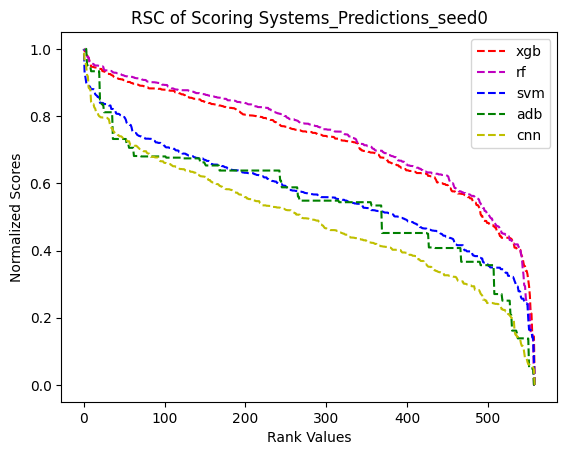

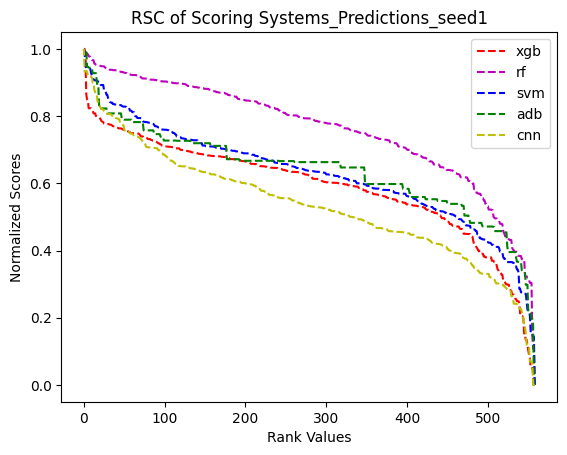

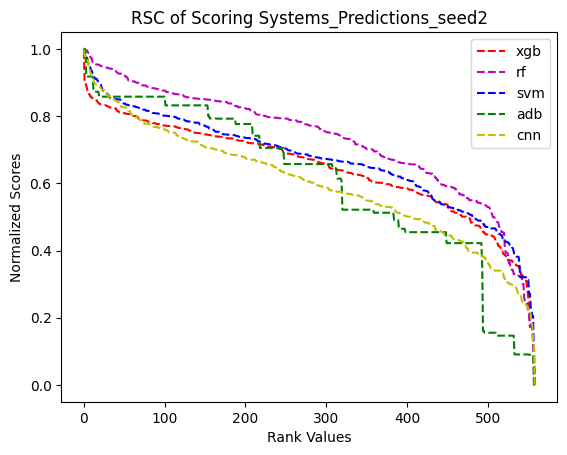

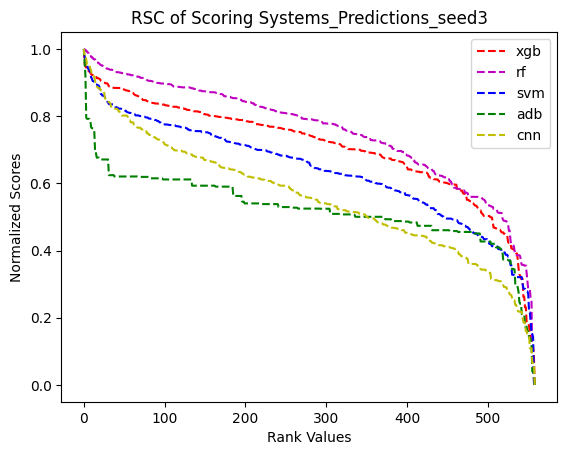

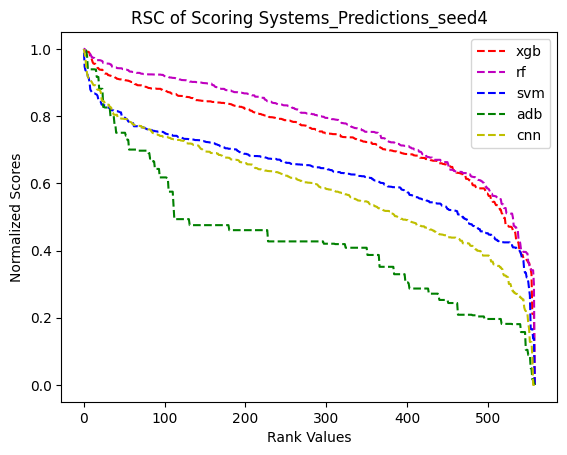

In [ ]:
# RSC graphs
colors = ['r--', 'm--', 'b--', 'g--', 'y--']
ranks = np.flip(np.arange(len(predictions_xgb[0])))

for seed in range(len(globals()['predictions_list_%s' % sys])):
  for z in range(len(scoreSys)):
    globals()['line%s' % (z+1)] = plt.plot(ranks, np.sort(normalize(globals()['predictions_%s' % scoreSys[z]][seed])), colors[z], label = scoreSys[z])
    plt.legend(loc = 'upper right')
    plt.title('RSC of Scoring Systems_Predictions_seed%s' % seed)
    plt.xlabel('Rank Values')
    plt.ylabel('Normalized Scores')
  plt.show()


In [ ]:
ds_score = [[] for _ in range(5)]

In [ ]:
for sys in scoreSys:
  for seed in range(len(ds_score)):
    loc = scoreSys.index(sys)
    scoreSys.remove(sys)
    ds = 0
    for i in range(len(scoreSys)):
      ds += np.sum(np.square(normalize(np.sort(globals()['predictions_%s' % sys][seed]))-normalize(np.sort(globals()['predictions_%s' % scoreSys[i]][seed]))))
    ds = ds/len(scoreSys)
    scoreSys.insert(loc, sys)
    ds_score[seed].append(ds)

In [ ]:
ds_score

[[15.926757227264634,
  18.79366839767595,
  8.969767806858336,
  10.947269865919148,
  18.638471355909253],
 [5.531814623933921,
  16.356396959113034,
  4.279436995799063,
  4.710272442077338,
  10.93776358343114],
 [3.342819286659579,
  7.390014455495017,
  3.556313170785271,
  7.4121859983201634,
  4.924063836602655],
 [9.735066439135835,
  15.922651485216619,
  6.074838128700086,
  16.67297667940772,
  11.213211836687998],
 [20.76465037374175,
  26.635346952673466,
  12.09359808410685,
  43.619298489819826,
  13.560355766879365]]

In [ ]:
ds_rank = np.reciprocal(ds_score)

In [ ]:
ds_rank

array([[0.06278742, 0.05320941, 0.11148561, 0.09134698, 0.05365247],
       [0.18077251, 0.06113816, 0.2336756 , 0.21230194, 0.09142637],
       [0.29914869, 0.13531773, 0.28119008, 0.13491297, 0.20308429],
       [0.10272144, 0.06280361, 0.16461344, 0.05997729, 0.08918051],
       [0.04815877, 0.0375441 , 0.08268838, 0.02292563, 0.07374438]])

In [ ]:
def mean_absolute_error(y_pred, y_test):
  res = np.mean(np.abs(y_pred - y_test))
  return res

In [ ]:
ps_score = [[] for _ in range(5)]

In [ ]:
def spearman_corr(y_pred_rank, y_test_rank):
  n = len(y_pred_rank)
  res = 1 - 6 * np.sum((y_pred_rank - y_test_rank)**2) / (n*(n**2-1))
  return res

In [ ]:
for sys in scoreSys:
  for seed in range(len(ps_score)):
    ps = mean_absolute_error(globals()['predictions_%s' % sys][seed], y_test)
    ps_score[seed].append(ps)

In [ ]:
ps_score

[[10.15571447942755,
  10.081907467853311,
  9.566225428479429,
  14.593567470107335,
  13.503903661896242],
 [10.190399998211092,
  10.595908894991057,
  9.251685875563506,
  17.851243894543828,
  12.506616960644006],
 [9.86236598211091,
  10.450783388783544,
  8.794776318443649,
  13.008420522110912,
  11.994358681574239],
 [9.914158749552772,
  10.282419441449017,
  8.675240722039355,
  22.12609710826476,
  11.867615014311271],
 [9.851106413237924,
  10.516276220876566,
  9.250515524007156,
  19.789656377012523,
  12.376048790697673]]

In [ ]:
def powerset(s):
    x = len(s)
    ls = []
    for i in range(1 << x):
        ls.append([s[j] for j in range(x) if (i & (1 << j))])
    return ls[1:]

models = powerset(scoreSys)

def myFunc(e):
  return len(e)

models.sort(key=myFunc)

models_list = []
for i in range(len(models)):
  if len(models[i]) == 1:
    models_list.append(models[i][0])
  elif len(models[i]) == 2:
    models_list.append(models[i][0]+'&'+models[i][1])
  elif len(models[i]) == 3:
    models_list.append(models[i][0]+'&'+models[i][1]+'&'+models[i][2])
  elif len(models[i]) == 4:
    models_list.append(models[i][0]+'&'+models[i][1]+'&'+models[i][2]+'&'+models[i][3])
  elif len(models[i]) == 5:
    models_list.append(models[i][0]+'&'+models[i][1]+'&'+models[i][2]+'&'+models[i][3]+'&'+models[i][4])

In [ ]:
models_list

['xgb',
 'rf',
 'svm',
 'adb',
 'cnn',
 'xgb&rf',
 'xgb&svm',
 'rf&svm',
 'xgb&adb',
 'rf&adb',
 'svm&adb',
 'xgb&cnn',
 'rf&cnn',
 'svm&cnn',
 'adb&cnn',
 'xgb&rf&svm',
 'xgb&rf&adb',
 'xgb&svm&adb',
 'rf&svm&adb',
 'xgb&rf&cnn',
 'xgb&svm&cnn',
 'rf&svm&cnn',
 'xgb&adb&cnn',
 'rf&adb&cnn',
 'svm&adb&cnn',
 'xgb&rf&svm&adb',
 'xgb&rf&svm&cnn',
 'xgb&rf&adb&cnn',
 'xgb&svm&adb&cnn',
 'rf&svm&adb&cnn',
 'xgb&rf&svm&adb&cnn']

# Perform average score combinations

In [ ]:
avg_score_combine_seed1 = pd.DataFrame({'xgb':predictions_xgb[0], 'rf':predictions_rf[0], 'svm':predictions_svm[0], 'adb':predictions_adb[0], 'cnn':predictions_cnn[0]})
avg_score_combine_seed2 = pd.DataFrame({'xgb':predictions_xgb[1], 'rf':predictions_rf[1], 'svm':predictions_svm[1], 'adb':predictions_adb[1], 'cnn':predictions_cnn[1]})
avg_score_combine_seed3 = pd.DataFrame({'xgb':predictions_xgb[2], 'rf':predictions_rf[2], 'svm':predictions_svm[2], 'adb':predictions_adb[2], 'cnn':predictions_cnn[2]})
avg_score_combine_seed4 = pd.DataFrame({'xgb':predictions_xgb[3], 'rf':predictions_rf[3], 'svm':predictions_svm[3], 'adb':predictions_adb[3], 'cnn':predictions_cnn[3]})
avg_score_combine_seed5 = pd.DataFrame({'xgb':predictions_xgb[4], 'rf':predictions_rf[4], 'svm':predictions_svm[4], 'adb':predictions_adb[4], 'cnn':predictions_cnn[4]})

In [ ]:
def avg_score_combine(models_list, single_score):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      single_score[j] = (single_score[j.split('&')[0]]+single_score[j.split('&')[1]]) / 2
    elif len(j.split('&')) == 3:
      single_score[j] = (single_score[j.split('&')[0]]+single_score[j.split('&')[1]]+single_score[j.split('&')[2]]) / 3
    elif len(j.split('&')) == 4:
      single_score[j] = (single_score[j.split('&')[0]]+single_score[j.split('&')[1]]+single_score[j.split('&')[2]]+single_score[j.split('&')[3]]) / 4
    elif len(j.split('&')) == 5:
      single_score[j] = (single_score[j.split('&')[0]]+single_score[j.split('&')[1]]+single_score[j.split('&')[2]]+single_score[j.split('&')[3]]+single_score[j.split('&')[4]]) / 5

In [ ]:
avg_score_combine(models_list, avg_score_combine_seed1)
avg_score_combine(models_list, avg_score_combine_seed2)
avg_score_combine(models_list, avg_score_combine_seed3)
avg_score_combine(models_list, avg_score_combine_seed4)
avg_score_combine(models_list, avg_score_combine_seed5)

# Perform average rank combinations

In [ ]:
def score_to_rank(array):
  res = np.argsort(np.flip(np.argsort(array)))+1
  return res

In [ ]:
avg_rank_combine_seed1 = pd.DataFrame({'xgb':score_to_rank(predictions_xgb[0]), 'rf':score_to_rank(predictions_rf[0]), 'svm':score_to_rank(predictions_svm[0]), 'adb':score_to_rank(predictions_adb[0]), 'cnn':score_to_rank(predictions_cnn[0])})
avg_rank_combine_seed2 = pd.DataFrame({'xgb':score_to_rank(predictions_xgb[1]), 'rf':score_to_rank(predictions_rf[1]), 'svm':score_to_rank(predictions_svm[1]), 'adb':score_to_rank(predictions_adb[1]), 'cnn':score_to_rank(predictions_cnn[1])})
avg_rank_combine_seed3 = pd.DataFrame({'xgb':score_to_rank(predictions_xgb[2]), 'rf':score_to_rank(predictions_rf[2]), 'svm':score_to_rank(predictions_svm[2]), 'adb':score_to_rank(predictions_adb[2]), 'cnn':score_to_rank(predictions_cnn[2])})
avg_rank_combine_seed4 = pd.DataFrame({'xgb':score_to_rank(predictions_xgb[3]), 'rf':score_to_rank(predictions_rf[3]), 'svm':score_to_rank(predictions_svm[3]), 'adb':score_to_rank(predictions_adb[3]), 'cnn':score_to_rank(predictions_cnn[3])})
avg_rank_combine_seed5 = pd.DataFrame({'xgb':score_to_rank(predictions_xgb[4]), 'rf':score_to_rank(predictions_rf[4]), 'svm':score_to_rank(predictions_svm[4]), 'adb':score_to_rank(predictions_adb[4]), 'cnn':score_to_rank(predictions_cnn[4])})

In [ ]:
def avg_rank_combine(models_list, single_rank):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      single_rank[j+'_r'] = (single_rank[j.split('&')[0]]+single_rank[j.split('&')[1]]) / 2
    elif len(j.split('&')) == 3:
      single_rank[j+'_r'] = (single_rank[j.split('&')[0]]+single_rank[j.split('&')[1]]+single_rank[j.split('&')[2]]) / 3
    elif len(j.split('&')) == 4:
      single_rank[j+'_r'] = (single_rank[j.split('&')[0]]+single_rank[j.split('&')[1]]+single_rank[j.split('&')[2]]+single_rank[j.split('&')[3]]) / 4
    elif len(j.split('&')) == 5:
      single_rank[j+'_r'] = (single_rank[j.split('&')[0]]+single_rank[j.split('&')[1]]+single_rank[j.split('&')[2]]+single_rank[j.split('&')[3]]+single_rank[j.split('&')[4]]) / 5

In [ ]:
avg_rank_combine(models_list, avg_rank_combine_seed1)
avg_rank_combine(models_list, avg_rank_combine_seed2)
avg_rank_combine(models_list, avg_rank_combine_seed3)
avg_rank_combine(models_list, avg_rank_combine_seed4)
avg_rank_combine(models_list, avg_rank_combine_seed5)

# Perform weighted score combination by diversity strength

In [ ]:
ds_score_combine_seed1 = pd.DataFrame()
ds_score_combine_seed2 = pd.DataFrame()
ds_score_combine_seed3 = pd.DataFrame()
ds_score_combine_seed4 = pd.DataFrame()
ds_score_combine_seed5 = pd.DataFrame()

In [ ]:
def ds_score_combine(models_list, single_score, ds_score_combine, ds_score):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      ds_score_combine[j+'_ds'] = (single_score[j.split('&')[0]]*ds_score[scoreSys.index(j.split('&')[0])]+single_score[j.split('&')[1]]*ds_score[scoreSys.index(j.split('&')[1])])/(ds_score[scoreSys.index(j.split('&')[0])] + ds_score[scoreSys.index(j.split('&')[1])])
    elif len(j.split('&')) == 3:
      ds_score_combine[j+'_ds'] = (single_score[j.split('&')[0]]*ds_score[scoreSys.index(j.split('&')[0])]+single_score[j.split('&')[1]]*ds_score[scoreSys.index(j.split('&')[1])]+single_score[j.split('&')[2]]*ds_score[scoreSys.index(j.split('&')[2])])/(ds_score[scoreSys.index(j.split('&')[0])] + ds_score[scoreSys.index(j.split('&')[1])] + ds_score[scoreSys.index(j.split('&')[2])])
    elif len(j.split('&')) == 4:
      ds_score_combine[j+'_ds'] = (single_score[j.split('&')[0]]*ds_score[scoreSys.index(j.split('&')[0])]+single_score[j.split('&')[1]]*ds_score[scoreSys.index(j.split('&')[1])]+single_score[j.split('&')[2]]*ds_score[scoreSys.index(j.split('&')[2])]+single_score[j.split('&')[3]]*ds_score[scoreSys.index(j.split('&')[3])])/(ds_score[scoreSys.index(j.split('&')[0])] + ds_score[scoreSys.index(j.split('&')[1])] + ds_score[scoreSys.index(j.split('&')[2])] + ds_score[scoreSys.index(j.split('&')[3])])
    elif len(j.split('&')) == 5:
      ds_score_combine[j+'_ds'] = (single_score[j.split('&')[0]]*ds_score[scoreSys.index(j.split('&')[0])]+single_score[j.split('&')[1]]*ds_score[scoreSys.index(j.split('&')[1])]+single_score[j.split('&')[2]]*ds_score[scoreSys.index(j.split('&')[2])]+single_score[j.split('&')[3]]*ds_score[scoreSys.index(j.split('&')[3])]+single_score[j.split('&')[4]]*ds_score[scoreSys.index(j.split('&')[4])])/(ds_score[scoreSys.index(j.split('&')[0])] + ds_score[scoreSys.index(j.split('&')[1])] + ds_score[scoreSys.index(j.split('&')[2])] + ds_score[scoreSys.index(j.split('&')[3])] + ds_score[scoreSys.index(j.split('&')[4])])

In [ ]:
ds_score_combine(models_list, avg_score_combine_seed1, ds_score_combine_seed1, ds_score[0])
ds_score_combine(models_list, avg_score_combine_seed2, ds_score_combine_seed2, ds_score[1])
ds_score_combine(models_list, avg_score_combine_seed3, ds_score_combine_seed3, ds_score[2])
ds_score_combine(models_list, avg_score_combine_seed4, ds_score_combine_seed4, ds_score[3])
ds_score_combine(models_list, avg_score_combine_seed5, ds_score_combine_seed5, ds_score[4])

# Perform weighted rank combination by diversity strength

In [ ]:
ds_rank_combine_seed1 = pd.DataFrame()
ds_rank_combine_seed2 = pd.DataFrame()
ds_rank_combine_seed3 = pd.DataFrame()
ds_rank_combine_seed4 = pd.DataFrame()
ds_rank_combine_seed5 = pd.DataFrame()

In [ ]:
def ds_rank_combine(models_list, single_rank, ds_rank_combine, ds_rank):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      ds_rank_combine[j+'_ds_r'] = (single_rank[j.split('&')[0]]*ds_rank[scoreSys.index(j.split('&')[0])]+single_rank[j.split('&')[1]]*ds_rank[scoreSys.index(j.split('&')[1])])/(ds_rank[scoreSys.index(j.split('&')[0])] + ds_rank[scoreSys.index(j.split('&')[1])])
    elif len(j.split('&')) == 3:
      ds_rank_combine[j+'_ds_r'] = (single_rank[j.split('&')[0]]*ds_rank[scoreSys.index(j.split('&')[0])]+single_rank[j.split('&')[1]]*ds_rank[scoreSys.index(j.split('&')[1])]+single_rank[j.split('&')[2]]*ds_rank[scoreSys.index(j.split('&')[2])])/(ds_rank[scoreSys.index(j.split('&')[0])] + ds_rank[scoreSys.index(j.split('&')[1])] + ds_rank[scoreSys.index(j.split('&')[2])])
    elif len(j.split('&')) == 4:
      ds_rank_combine[j+'_ds_r'] = (single_rank[j.split('&')[0]]*ds_rank[scoreSys.index(j.split('&')[0])]+single_rank[j.split('&')[1]]*ds_rank[scoreSys.index(j.split('&')[1])]+single_rank[j.split('&')[2]]*ds_rank[scoreSys.index(j.split('&')[2])]+single_rank[j.split('&')[3]]*ds_rank[scoreSys.index(j.split('&')[3])])/(ds_rank[scoreSys.index(j.split('&')[0])] + ds_rank[scoreSys.index(j.split('&')[1])] + ds_rank[scoreSys.index(j.split('&')[2])] + ds_rank[scoreSys.index(j.split('&')[3])])
    elif len(j.split('&')) == 5:
      ds_rank_combine[j+'_ds_r'] = (single_rank[j.split('&')[0]]*ds_rank[scoreSys.index(j.split('&')[0])]+single_rank[j.split('&')[1]]*ds_rank[scoreSys.index(j.split('&')[1])]+single_rank[j.split('&')[2]]*ds_rank[scoreSys.index(j.split('&')[2])]+single_rank[j.split('&')[3]]*ds_rank[scoreSys.index(j.split('&')[3])]+single_rank[j.split('&')[4]]*ds_rank[scoreSys.index(j.split('&')[4])])/(ds_rank[scoreSys.index(j.split('&')[0])] + ds_rank[scoreSys.index(j.split('&')[1])] + ds_rank[scoreSys.index(j.split('&')[2])] + ds_rank[scoreSys.index(j.split('&')[3])] + ds_rank[scoreSys.index(j.split('&')[4])])

In [ ]:
ds_rank_combine(models_list, avg_rank_combine_seed1, ds_rank_combine_seed1, ds_rank[0])
ds_rank_combine(models_list, avg_rank_combine_seed2, ds_rank_combine_seed2, ds_rank[1])
ds_rank_combine(models_list, avg_rank_combine_seed3, ds_rank_combine_seed3, ds_rank[2])
ds_rank_combine(models_list, avg_rank_combine_seed4, ds_rank_combine_seed4, ds_rank[3])
ds_rank_combine(models_list, avg_rank_combine_seed5, ds_rank_combine_seed5, ds_rank[4])

# Perform weighted score combination by performance strength (MAE)

In [ ]:
ps_score_combine_seed1 = pd.DataFrame()
ps_score_combine_seed2 = pd.DataFrame()
ps_score_combine_seed3 = pd.DataFrame()
ps_score_combine_seed4 = pd.DataFrame()
ps_score_combine_seed5 = pd.DataFrame()

In [ ]:
def ps_score_combine(models_list, single_score, ps_score_combine, ps_score):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      ps_score_combine[j+'_ps'] = (single_score[j.split('&')[0]]*(1 / ps_score[scoreSys.index(j.split('&')[0])])+single_score[j.split('&')[1]]*(1 / ps_score[scoreSys.index(j.split('&')[1])]))/(1 / ps_score[scoreSys.index(j.split('&')[0])] + 1 / ps_score[scoreSys.index(j.split('&')[1])])
    elif len(j.split('&')) == 3:
      ps_score_combine[j+'_ps'] = (single_score[j.split('&')[0]]*(1 / ps_score[scoreSys.index(j.split('&')[0])])+single_score[j.split('&')[1]]*(1 / ps_score[scoreSys.index(j.split('&')[1])])+single_score[j.split('&')[2]]*(1 / ps_score[scoreSys.index(j.split('&')[2])]))/(1 / ps_score[scoreSys.index(j.split('&')[0])] + 1 / ps_score[scoreSys.index(j.split('&')[1])] + 1 / ps_score[scoreSys.index(j.split('&')[2])])
    elif len(j.split('&')) == 4:
      ps_score_combine[j+'_ps'] = (single_score[j.split('&')[0]]*(1 / ps_score[scoreSys.index(j.split('&')[0])])+single_score[j.split('&')[1]]*(1 / ps_score[scoreSys.index(j.split('&')[1])])+single_score[j.split('&')[2]]*(1 / ps_score[scoreSys.index(j.split('&')[2])])+single_score[j.split('&')[3]]*(1 / ps_score[scoreSys.index(j.split('&')[3])]))/(1 / ps_score[scoreSys.index(j.split('&')[0])] + 1 / ps_score[scoreSys.index(j.split('&')[1])] + 1 / ps_score[scoreSys.index(j.split('&')[2])] + ps_score[scoreSys.index(j.split('&')[3])])
    elif len(j.split('&')) == 5:
      ps_score_combine[j+'_ps'] = (single_score[j.split('&')[0]]*(1 / ps_score[scoreSys.index(j.split('&')[0])])+single_score[j.split('&')[1]]*(1 / ps_score[scoreSys.index(j.split('&')[1])])+single_score[j.split('&')[2]]*(1 / ps_score[scoreSys.index(j.split('&')[2])])+single_score[j.split('&')[3]]*(1 / ps_score[scoreSys.index(j.split('&')[3])])+single_score[j.split('&')[4]]*(1 / ps_score[scoreSys.index(j.split('&')[4])]))/(1 / ps_score[scoreSys.index(j.split('&')[0])] + 1 / ps_score[scoreSys.index(j.split('&')[1])] + 1 / ps_score[scoreSys.index(j.split('&')[2])] + 1 / ps_score[scoreSys.index(j.split('&')[3])] + 1 / ps_score[scoreSys.index(j.split('&')[4])])

In [ ]:
ps_score_combine(models_list, avg_score_combine_seed1, ps_score_combine_seed1, ps_score[0])
ps_score_combine(models_list, avg_score_combine_seed2, ps_score_combine_seed2, ps_score[1])
ps_score_combine(models_list, avg_score_combine_seed3, ps_score_combine_seed3, ps_score[2])
ps_score_combine(models_list, avg_score_combine_seed4, ps_score_combine_seed4, ps_score[3])
ps_score_combine(models_list, avg_score_combine_seed5, ps_score_combine_seed5, ps_score[4])

# Perform weighted rank combination by performance strength

In [ ]:
ps_rank_combine_seed1 = pd.DataFrame()
ps_rank_combine_seed2 = pd.DataFrame()
ps_rank_combine_seed3 = pd.DataFrame()
ps_rank_combine_seed4 = pd.DataFrame()
ps_rank_combine_seed5 = pd.DataFrame()

In [ ]:
def ps_rank_combine(models_list, single_rank, ps_rank_combine, ps_score):
  for j in models_list[len(scoreSys):]:
    if len(j.split('&')) == 2:
      ps_rank_combine[j+'_ps_r'] = (single_rank[j.split('&')[0]]*(ps_score[scoreSys.index(j.split('&')[0])])+single_rank[j.split('&')[1]]*(ps_score[scoreSys.index(j.split('&')[1])]))/(ps_score[scoreSys.index(j.split('&')[0])] + ps_score[scoreSys.index(j.split('&')[1])])
    elif len(j.split('&')) == 3:
      ps_rank_combine[j+'_ps_r'] = (single_rank[j.split('&')[0]]*(ps_score[scoreSys.index(j.split('&')[0])])+single_rank[j.split('&')[1]]*(ps_score[scoreSys.index(j.split('&')[1])])+single_rank[j.split('&')[2]]*(ps_score[scoreSys.index(j.split('&')[2])]))/(ps_score[scoreSys.index(j.split('&')[0])] + ps_score[scoreSys.index(j.split('&')[1])] + ps_score[scoreSys.index(j.split('&')[2])])
    elif len(j.split('&')) == 4:
      ps_rank_combine[j+'_ps_r'] = (single_rank[j.split('&')[0]]*(ps_score[scoreSys.index(j.split('&')[0])])+single_rank[j.split('&')[1]]*(ps_score[scoreSys.index(j.split('&')[1])])+single_rank[j.split('&')[2]]*(ps_score[scoreSys.index(j.split('&')[2])])+single_rank[j.split('&')[3]]*(ps_score[scoreSys.index(j.split('&')[3])]))/(ps_score[scoreSys.index(j.split('&')[0])] + ps_score[scoreSys.index(j.split('&')[1])] + ps_score[scoreSys.index(j.split('&')[2])] + ps_score[scoreSys.index(j.split('&')[3])])
    elif len(j.split('&')) == 5:
      ps_rank_combine[j+'_ps_r'] = (single_rank[j.split('&')[0]]*(ps_score[scoreSys.index(j.split('&')[0])])+single_rank[j.split('&')[1]]*(ps_score[scoreSys.index(j.split('&')[1])])+single_rank[j.split('&')[2]]*(ps_score[scoreSys.index(j.split('&')[2])])+single_rank[j.split('&')[3]]*(ps_score[scoreSys.index(j.split('&')[3])])+single_rank[j.split('&')[4]]*(ps_score[scoreSys.index(j.split('&')[4])]))/(ps_score[scoreSys.index(j.split('&')[0])] + ps_score[scoreSys.index(j.split('&')[1])] + ps_score[scoreSys.index(j.split('&')[2])] + ps_score[scoreSys.index(j.split('&')[3])] + ps_score[scoreSys.index(j.split('&')[4])])

In [ ]:
ps_rank_combine(models_list, avg_rank_combine_seed1, ps_rank_combine_seed1, ps_score[0])
ps_rank_combine(models_list, avg_rank_combine_seed2, ps_rank_combine_seed2, ps_score[1])
ps_rank_combine(models_list, avg_rank_combine_seed3, ps_rank_combine_seed3, ps_score[2])
ps_rank_combine(models_list, avg_rank_combine_seed4, ps_rank_combine_seed4, ps_score[3])
ps_rank_combine(models_list, avg_rank_combine_seed5, ps_rank_combine_seed5, ps_score[4])

In [ ]:
avg_rank_combine_seed1.rename(columns={'xgb': 'xgb_r', 'rf': 'rf_r', 'svm': 'svm_r', 'adb': 'adb_r', 'cnn': 'cnn_r'}, inplace=True)
avg_rank_combine_seed2.rename(columns={'xgb': 'xgb_r', 'rf': 'rf_r', 'svm': 'svm_r', 'adb': 'adb_r', 'cnn': 'cnn_r'}, inplace=True)
avg_rank_combine_seed3.rename(columns={'xgb': 'xgb_r', 'rf': 'rf_r', 'svm': 'svm_r', 'adb': 'adb_r', 'cnn': 'cnn_r'}, inplace=True)
avg_rank_combine_seed4.rename(columns={'xgb': 'xgb_r', 'rf': 'rf_r', 'svm': 'svm_r', 'adb': 'adb_r', 'cnn': 'cnn_r'}, inplace=True)
avg_rank_combine_seed5.rename(columns={'xgb': 'xgb_r', 'rf': 'rf_r', 'svm': 'svm_r', 'adb': 'adb_r', 'cnn': 'cnn_r'}, inplace=True)

# Calculate MAE

In [ ]:
score_combine_list = np.hstack((np.array(avg_score_combine_seed1.columns), np.array(ds_score_combine_seed1.columns), np.array(ps_score_combine_seed1.columns)))
MAE = pd.DataFrame(index = score_combine_list)
for i in range(1, 6):
  mae_avg, mae_ds, mae_ps = [], [], []
  for col in globals()['avg_score_combine_seed%s' %i].columns:
    mae = mean_absolute_error(np.array(globals()['avg_score_combine_seed%s' %i][col]), y_test)
    mae_avg.append(mae)
  for col in globals()['ds_score_combine_seed%s' %i].columns:
    mae = mean_absolute_error(np.array(globals()['ds_score_combine_seed%s' %i][col]), y_test)
    mae_ds.append(mae)
  for col in globals()['ps_score_combine_seed%s' %i].columns:
    mae = mean_absolute_error(np.array(globals()['ps_score_combine_seed%s' %i][col]), y_test)
    mae_ps.append(mae)
  MAE['seed'+str(i)] = np.hstack((mae_avg, mae_ds, mae_ps))

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
MAE['avg_MAE'] = MAE.mean(axis=1)

In [ ]:
MAE.sort_values(by='avg_MAE')

,seed1,seed2,seed3,seed4,seed5,avg_MAE
xgb&rf&svm_ps,8.861225,9.069643,8.840131,8.843761,8.891880,8.901328
xgb&svm_ps,9.261830,9.004391,8.656394,8.681034,8.935432,8.907816
rf&svm_ps,8.938110,8.983607,8.952906,8.838666,8.921111,8.926880
xgb&svm,9.274072,9.031378,8.689845,8.727855,8.950019,8.934634
xgb&rf&svm,8.870998,9.116710,8.896267,8.897701,8.926921,8.941719
rf&svm,8.951147,9.035233,9.030910,8.911753,8.972411,8.980291
xgb&svm_ds,9.420113,9.117238,8.670521,8.917422,9.107833,9.046625
svm,9.566225,9.251686,8.794776,8.675241,9.250516,9.107689
rf&svm&cnn_ps,9.333055,9.360331,8.907775,9.007552,8.973353,9.116413
xgb&rf&svm&cnn,9.400694,9.438670,8.920084,9.018564,8.999158,9.155434


In [ ]:
y_test_rank = score_to_rank(y_test)

spearman_corr_score_func = pd.DataFrame(index = score_combine_list)
for i in range(1, 6):
  sc_score_avg, sc_score_ds, sc_score_ps = [], [], []
  for col in globals()['avg_score_combine_seed%s' %i].columns:
    sc = get_spearman_corr(np.array(score_to_rank(globals()['avg_score_combine_seed%s' %i][col])), y_test_rank)
    sc_score_avg.append(sc)
  for col in globals()['ds_score_combine_seed%s' %i].columns:
    sc = get_spearman_corr(np.array(score_to_rank(globals()['ds_score_combine_seed%s' %i][col])), y_test_rank)
    sc_score_ds.append(sc)
  for col in globals()['ps_score_combine_seed%s' %i].columns:
    sc = get_spearman_corr(np.array(score_to_rank(globals()['ps_score_combine_seed%s' %i][col])), y_test_rank)
    sc_score_ps.append(sc)
  spearman_corr_score_func['seed'+str(i)] = np.hstack((sc_score_avg, sc_score_ds, sc_score_ps))

spearman_corr_score_func['avg_spearman'] = spearman_corr_score_func.mean(axis=1)

spearman_corr_score_func.sort_values(by='avg_spearman',ascending=False)

,seed1,seed2,seed3,seed4,seed5,avg_spearman
xgb&rf&svm&adb_ps,0.449744,0.450890,0.507971,0.516087,0.497922,0.484523
xgb&rf&svm&adb,0.451156,0.446737,0.507073,0.514384,0.493742,0.482618
xgb&rf&svm_ps,0.443037,0.450328,0.502461,0.511367,0.495015,0.480441
xgb&svm&adb_ps,0.432200,0.453161,0.512031,0.518729,0.481581,0.479540
xgb&rf&svm,0.443159,0.449706,0.498833,0.507832,0.495925,0.479091
xgb&svm&adb,0.433061,0.447440,0.506254,0.522688,0.478614,0.477611
xgb&svm_ps,0.422724,0.458509,0.500904,0.511089,0.475226,0.473690
xgb&svm,0.423059,0.457232,0.500242,0.508440,0.475817,0.472958
xgb&svm&adb_ds,0.434056,0.447156,0.490764,0.524154,0.465853,0.472396
xgb&svm_ds,0.421223,0.456868,0.500558,0.498475,0.476208,0.470667


# Calculate Spearman's rank correlation

In [ ]:
y_test_rank = score_to_rank(y_test)

In [ ]:
'''def avg_footrule(y_pred_rank, y_test_rank):
  res = np.mean(np.abs(y_pred_rank - y_test_rank))
  return res'''

'def avg_footrule(y_pred_rank, y_test_rank):\n  res = np.mean(np.abs(y_pred_rank - y_test_rank))\n  return res'

In [ ]:
def get_spearman_corr(y_pred_rank, y_test_rank):
  n = len(y_pred_rank)
  res = 1 - 6 * np.sum((y_pred_rank - y_test_rank)**2) / (n*(n**2-1))
  return res

In [ ]:
rank_combine_list = np.hstack((np.array(avg_rank_combine_seed1.columns), np.array(ds_rank_combine_seed1.columns), np.array(ps_rank_combine_seed1.columns)))
spearman_corr = pd.DataFrame(index = rank_combine_list)
for i in range(1, 6):
  sc_avg, sc_ds, sc_ps = [], [], []
  for col in globals()['avg_rank_combine_seed%s' %i].columns:
    sc = get_spearman_corr(np.array(globals()['avg_rank_combine_seed%s' %i][col]), y_test_rank)
    sc_avg.append(sc)
  for col in globals()['ds_rank_combine_seed%s' %i].columns:
    sc = get_spearman_corr(np.array(globals()['ds_rank_combine_seed%s' %i][col]), y_test_rank)
    sc_ds.append(sc)
  for col in globals()['ps_rank_combine_seed%s' %i].columns:
    sc = get_spearman_corr(np.array(globals()['ps_rank_combine_seed%s' %i][col]), y_test_rank)
    sc_ps.append(sc)
  spearman_corr['seed'+str(i)] = np.hstack((sc_avg, sc_ds, sc_ps))


In [ ]:
pd.set_option("display.max_rows", None)

In [ ]:
spearman_corr['avg_spearman'] = spearman_corr.mean(axis=1)

In [ ]:
spearman_corr.sort_values(by='avg_spearman', ascending=False)

,seed1,seed2,seed3,seed4,seed5,avg_spearman
xgb&rf&svm&adb_r,0.554322,0.557612,0.582304,0.601767,0.577778,0.574756
xgb&rf&svm&adb&cnn_r,0.545458,0.560545,0.580862,0.598961,0.571022,0.571370
xgb&rf&adb&cnn_r,0.552169,0.553204,0.576751,0.594119,0.575266,0.570302
xgb&rf&svm&adb_ds_r,0.546790,0.552282,0.582143,0.600002,0.562575,0.568758
xgb&rf&svm&adb_ps_r,0.554082,0.547407,0.578495,0.592770,0.569022,0.568355
xgb&rf&svm&adb&cnn_ps_r,0.544179,0.555200,0.579725,0.594479,0.566464,0.568009
xgb&rf&adb&cnn_ps_r,0.548330,0.547002,0.575181,0.588394,0.566346,0.565051
xgb&rf&adb&cnn_ds_r,0.549673,0.539166,0.572321,0.591429,0.560302,0.562578
rf&svm&adb&cnn_r,0.545093,0.549406,0.568796,0.581587,0.559417,0.560860
xgb&rf&svm&adb&cnn_ds_r,0.539611,0.552259,0.573594,0.592744,0.545825,0.560807
